# Poker Hand Recognition

This project is aiming to train machine learning models to predict a 5-card hand in Poker game to identify its rank.

Authors/Contributers
- Ömer Faruk Merey (https://github.com/OmerFarukMerey)
- Ömer Davarcı (https://github.com/odavarci)

## 1. Importing and Installing Libraries

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!{sys.executable} -m pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!{sys.executable} -m pip install imblearn

Defaulting to user installation because normal site-packages is not writeable


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier


from xgboost import XGBClassifier
from xgboost import plot_importance
from catboost import CatBoostClassifier

from collections import Counter

from imblearn.over_sampling import SMOTE

import pickle

In [6]:
import warnings
warnings.filterwarnings('ignore')

## 2. About the Data

#### 2.1 Information
Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52.
Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. 

#### 2.2 Attribute Information
S1 "Suit of card #1" Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

C1 "Rank of card #1" Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

S2 "Suit of card #2" Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

C2 "Rank of card #2" Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

S3 "Suit of card #3" Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

C3 "Rank of card #3" Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

S4 "Suit of card #4" Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

C4 "Rank of card #4" Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

S5 "Suit of card #5" Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs}

C5 "Rank of card 5" Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King)

CLASS "Poker Hand" Ordinal (0-9)

0: Nothing in hand; not a recognized poker hand\
1: One pair; one pair of equal ranks within five cards\
2: Two pairs; two pairs of equal ranks within five cards\
3: Three of a kind; three equal ranks within five cards\
4: Straight; five cards, sequentially ranked with no gaps\
5: Flush; five cards with the same suit\
6: Full house; pair + different rank three of a kind\
7: Four of a kind; four equal ranks within five cards\
8: Straight flush; straight + flush\
9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush

## 3. Importing Data

In [7]:
X_test = pd.read_csv("poker-hand-testing.data")
X_train = pd.read_csv("poker-hand-training-true.data")

X_test.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5', 'Hand Rank']
X_train.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5', 'Hand Rank']

y_train = X_train["Hand Rank"]
y_test = X_test["Hand Rank"]

X_train = X_train.drop("Hand Rank", axis=1)
X_test = X_test.drop("Hand Rank", axis=1)

## 4. Explanatory Data Analysis (EDA)

Checking the sets.

In [8]:
X_train.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,2,11,2,13,2,10,2,12,2,1
1,3,12,3,11,3,13,3,10,3,1
2,4,10,4,11,4,1,4,13,4,12
3,4,1,4,13,4,12,4,11,4,10
4,1,2,1,4,1,5,1,3,1,6


In [9]:
X_test.head()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
0,3,12,3,2,3,11,4,5,2,5
1,1,9,4,6,1,4,3,2,3,9
2,1,4,3,13,2,13,2,1,3,6
3,3,10,2,7,1,2,2,11,4,9
4,1,3,4,5,3,4,1,12,4,6


Shape of test and train datasets

In [10]:
X_train.shape, X_test.shape

((25009, 10), (999999, 10))

Train and test information

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25009 entries, 0 to 25008
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   S1      25009 non-null  int64
 1   C1      25009 non-null  int64
 2   S2      25009 non-null  int64
 3   C2      25009 non-null  int64
 4   S3      25009 non-null  int64
 5   C3      25009 non-null  int64
 6   S4      25009 non-null  int64
 7   C4      25009 non-null  int64
 8   S5      25009 non-null  int64
 9   C5      25009 non-null  int64
dtypes: int64(10)
memory usage: 1.9 MB


In [12]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   S1      999999 non-null  int64
 1   C1      999999 non-null  int64
 2   S2      999999 non-null  int64
 3   C2      999999 non-null  int64
 4   S3      999999 non-null  int64
 5   C3      999999 non-null  int64
 6   S4      999999 non-null  int64
 7   C4      999999 non-null  int64
 8   S5      999999 non-null  int64
 9   C5      999999 non-null  int64
dtypes: int64(10)
memory usage: 76.3 MB


Mathematical description of our sets.

In [13]:
X_train.describe()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
count,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000,25009.000000
mean,2.508817,6.995122,2.497781,7.014035,2.510296,7.013915,2.495981,6.942261,2.497381,6.962973
std,1.116465,3.749832,1.121750,3.766965,1.123130,3.744858,1.115991,3.747086,1.118715,3.741463
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000
50%,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000,2.000000,7.000000,3.000000,7.000000
75%,4.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,3.000000,10.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000


In [14]:
X_test.describe()

,S1,C1,S2,C2,S3,C3,S4,C4,S5,C5
count,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000,999999.000000
mean,2.500495,6.997933,2.499895,7.006091,2.500872,6.998876,2.500394,7.002302,2.499452,6.989476
std,1.117767,3.743371,1.118568,3.743478,1.118225,3.741891,1.117246,3.741270,1.118948,3.739893
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,1.000000,4.000000,1.000000,4.000000,2.000000,4.000000,1.000000,4.000000
50%,3.000000,7.000000,3.000000,7.000000,3.000000,7.000000,3.000000,7.000000,2.000000,7.000000
75%,3.000000,10.000000,4.000000,10.000000,4.000000,10.000000,3.000000,10.000000,4.000000,10.000000
max,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000,4.000000,13.000000


The amount of ranks for each class.\
As seen in the cells below, our dataset (train) is extremely imbalanced.\
To solve this imbalancity and training the best model will be our main focus in this project.

In [15]:
y_train.groupby(y_train).size()

Hand Rank
0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
8        5
9        4
Name: Hand Rank, dtype: int64

In [16]:
y_test.groupby(y_test).size()

Hand Rank
0    501208
1    422498
2     47622
3     21121
4      3885
5      1996
6      1424
7       230
8        12
9         3
Name: Hand Rank, dtype: int64

The following code blocks contain the percentage of ranks in both the train and the test data sets.\
To observe the imbalancity.\
Also, there is a photo from Wikipedia.org to describe the real-life probabilities.\
Giving us a slight idea of how our distribution should be.

In [17]:
col_names = ["Nothing in hand", "One Pair", "Two Pair", "Three of a kind", "Straight"
            "Flush", "Full House", "Four of a kind", "Straight Flush", "Royal Flush"]

def percentage_shower(column_names, counts):
    _dict = dict()
    for index,col in enumerate(column_names):
        _dict[col] = (counts[index] / counts.sum()) * 100
    return _dict

In [18]:
percentage_dict_test = percentage_shower(col_names, y_test.groupby(y_test).size())
percentage_dict_train = percentage_shower(col_names, y_train.groupby(y_train).size())

In [19]:
pd_percentage_test = pd.DataFrame.from_dict(percentage_dict_test, orient='index', columns=["Percentage"])
pd_percentage_test

,Percentage
Nothing in hand,50.120850
One Pair,42.249842
Two Pair,4.762205
Three of a kind,2.112102
StraightFlush,0.388500
Full House,0.199600
Four of a kind,0.142400
Straight Flush,0.023000
Royal Flush,0.001200


In [20]:
pd_percentage_train = pd.DataFrame.from_dict(percentage_dict_train, orient='index', columns=["Percentage"])
pd_percentage_train

,Percentage
Nothing in hand,49.954017
One Pair,42.380743
Two Pair,4.822264
Three of a kind,2.051262
StraightFlush,0.371866
Full House,0.215922
Four of a kind,0.143948
Straight Flush,0.023991
Royal Flush,0.019993


Probability of Hand Ranks:

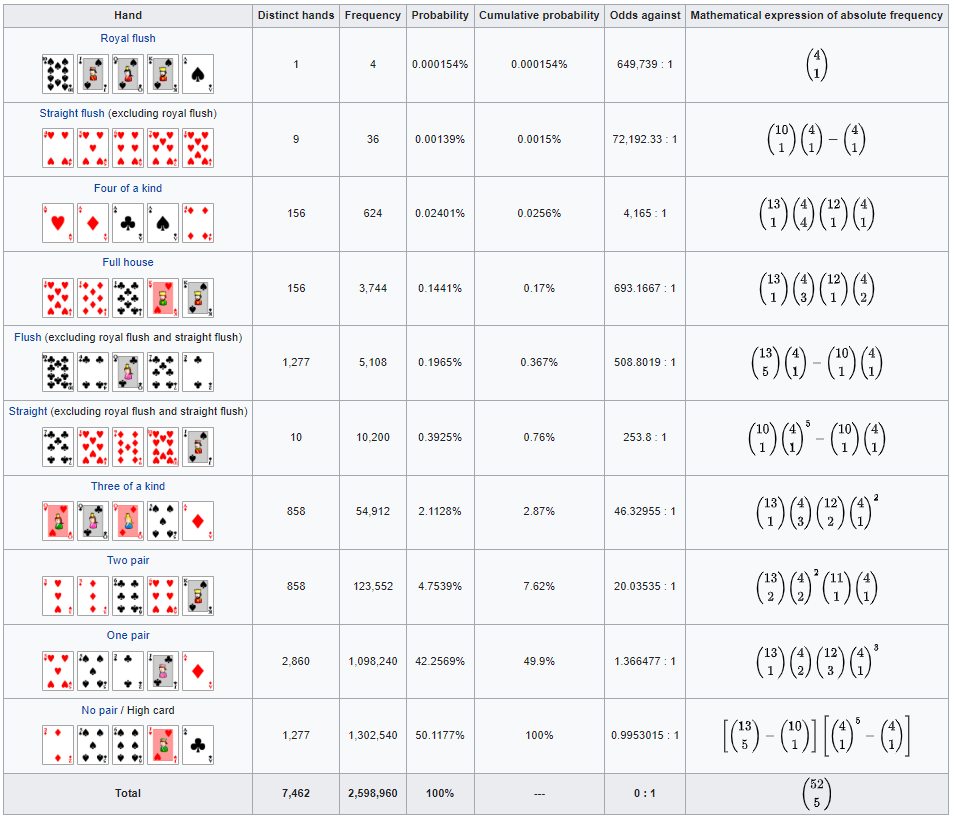

Link:https://en.wikipedia.org/wiki/Poker_probability

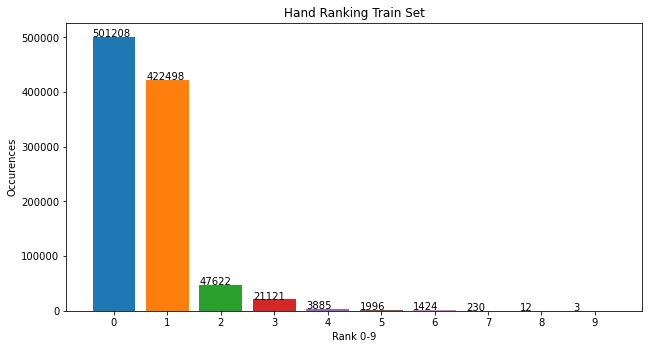

In [21]:
y = y_test.groupby(y_test).size()
hands = y.sum()
s = pd.DataFrame()
s["prob_hand"] = y.apply(lambda x: (x))
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,.8,.8])
ax.set_title('Hand Ranking Train Set')
ax.set_xlabel('Rank 0-9')
ax.set_ylabel('Occurences')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
for val in range(len(s)):
    ax.annotate(str(s.iloc[val,0]), xy = (val, s.iloc[val,0]), xytext = (val-.4, s.iloc[val,0]))
    ax.bar(val,s.iloc[val,0])
plt.show()

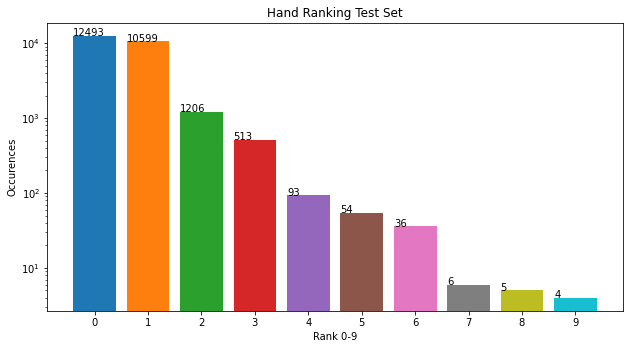

In [22]:
y = y_train.groupby(y_train).size()
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0.1,0.1,.8,.8])
ax.set_title('Hand Ranking Test Set')
ax.set_xlabel('Rank 0-9')
ax.set_ylabel('Occurences')
ax.set_yscale('log')
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
for val in range(len(y)):
    ax.annotate(str(y[val]), xy = (val, y[val]), xytext = (val-.4, y[val]))
    ax.bar(val,y[val])
plt.show()

X_train amounts of Cardinalities: 


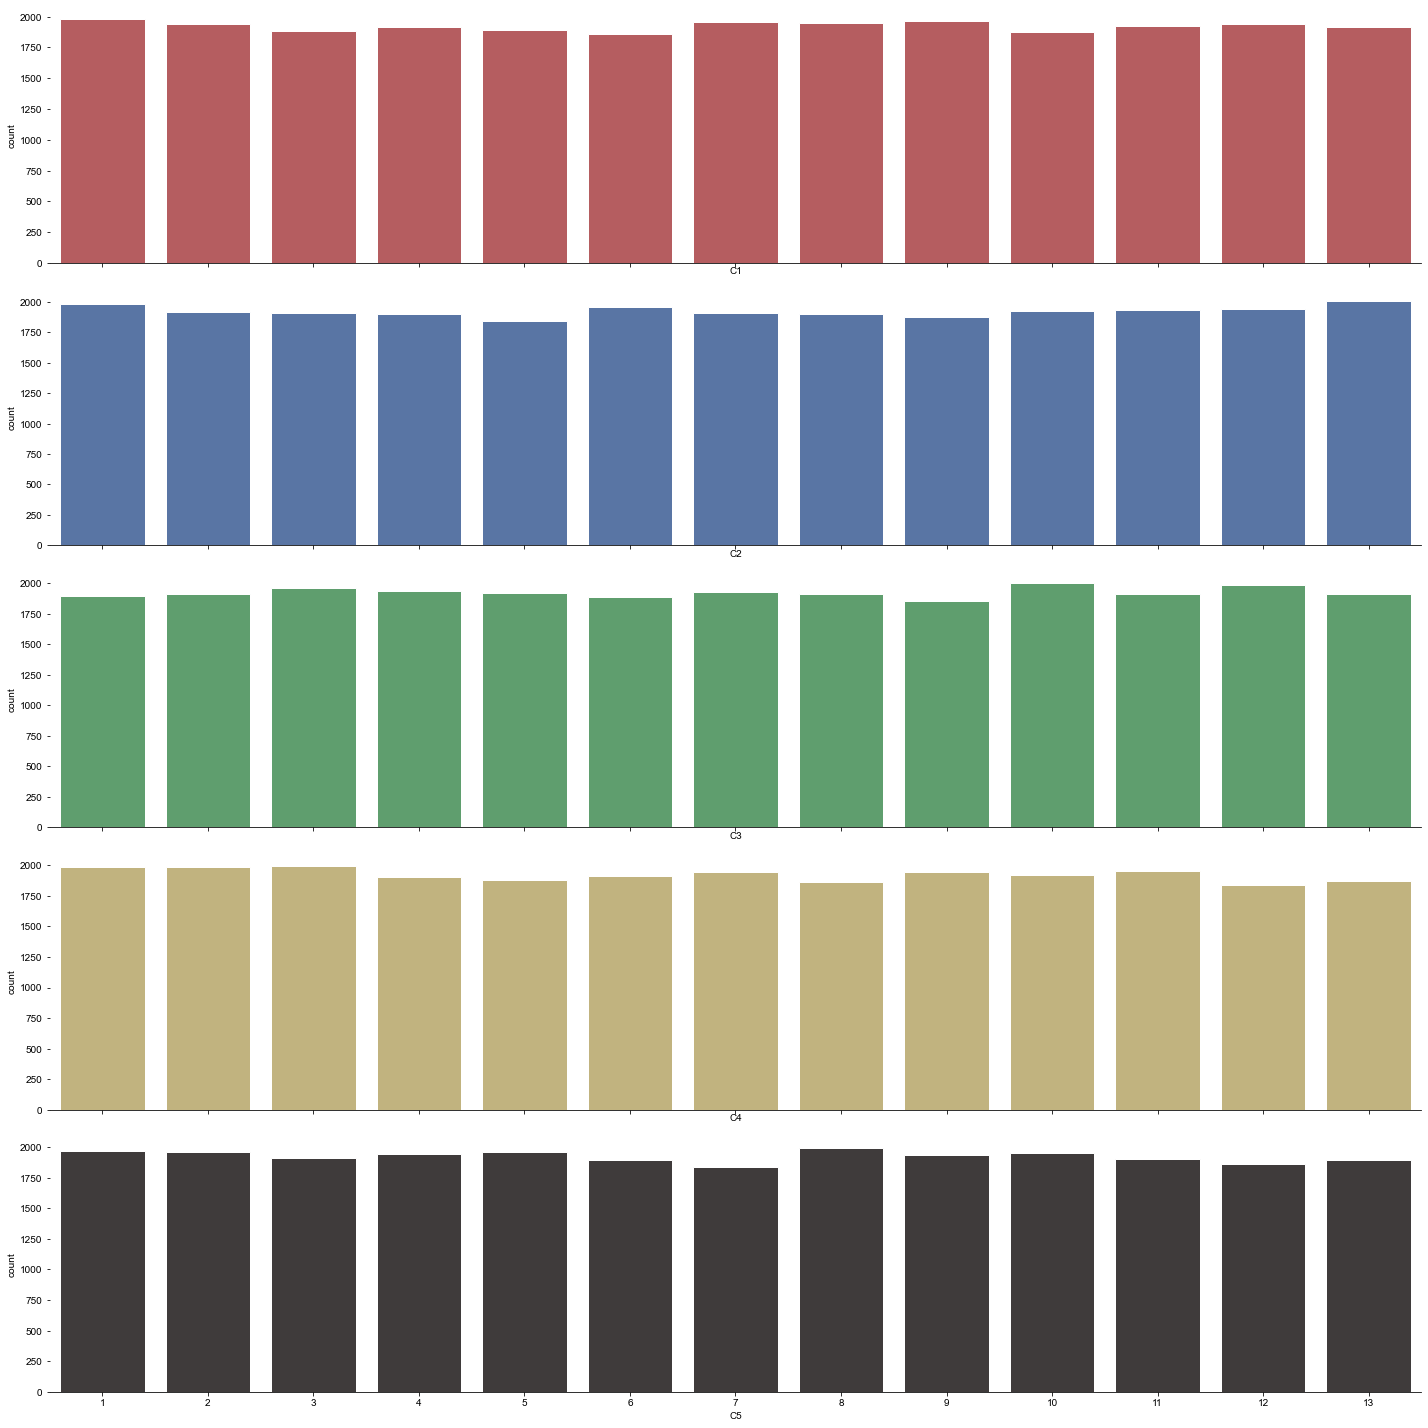

In [23]:
f, ax = plt.subplots(5, 1, figsize=(20, 20), sharex=True)
sns.set()
sns.despine(left=True)

print("X_train amounts of Cardinalities: ")

sns.countplot(X_train['C1'], color='r', ax=ax[0])

sns.countplot(X_train['C2'], color='b', ax=ax[1])

sns.countplot(X_train['C3'], color='g',ax=ax[2])

sns.countplot(X_train['C4'], color='y', ax=ax[3])

sns.countplot(X_train['C5'], color='#403A3A', ax=ax[4])

plt.tight_layout()

X_test amounts of Cardinalities: 


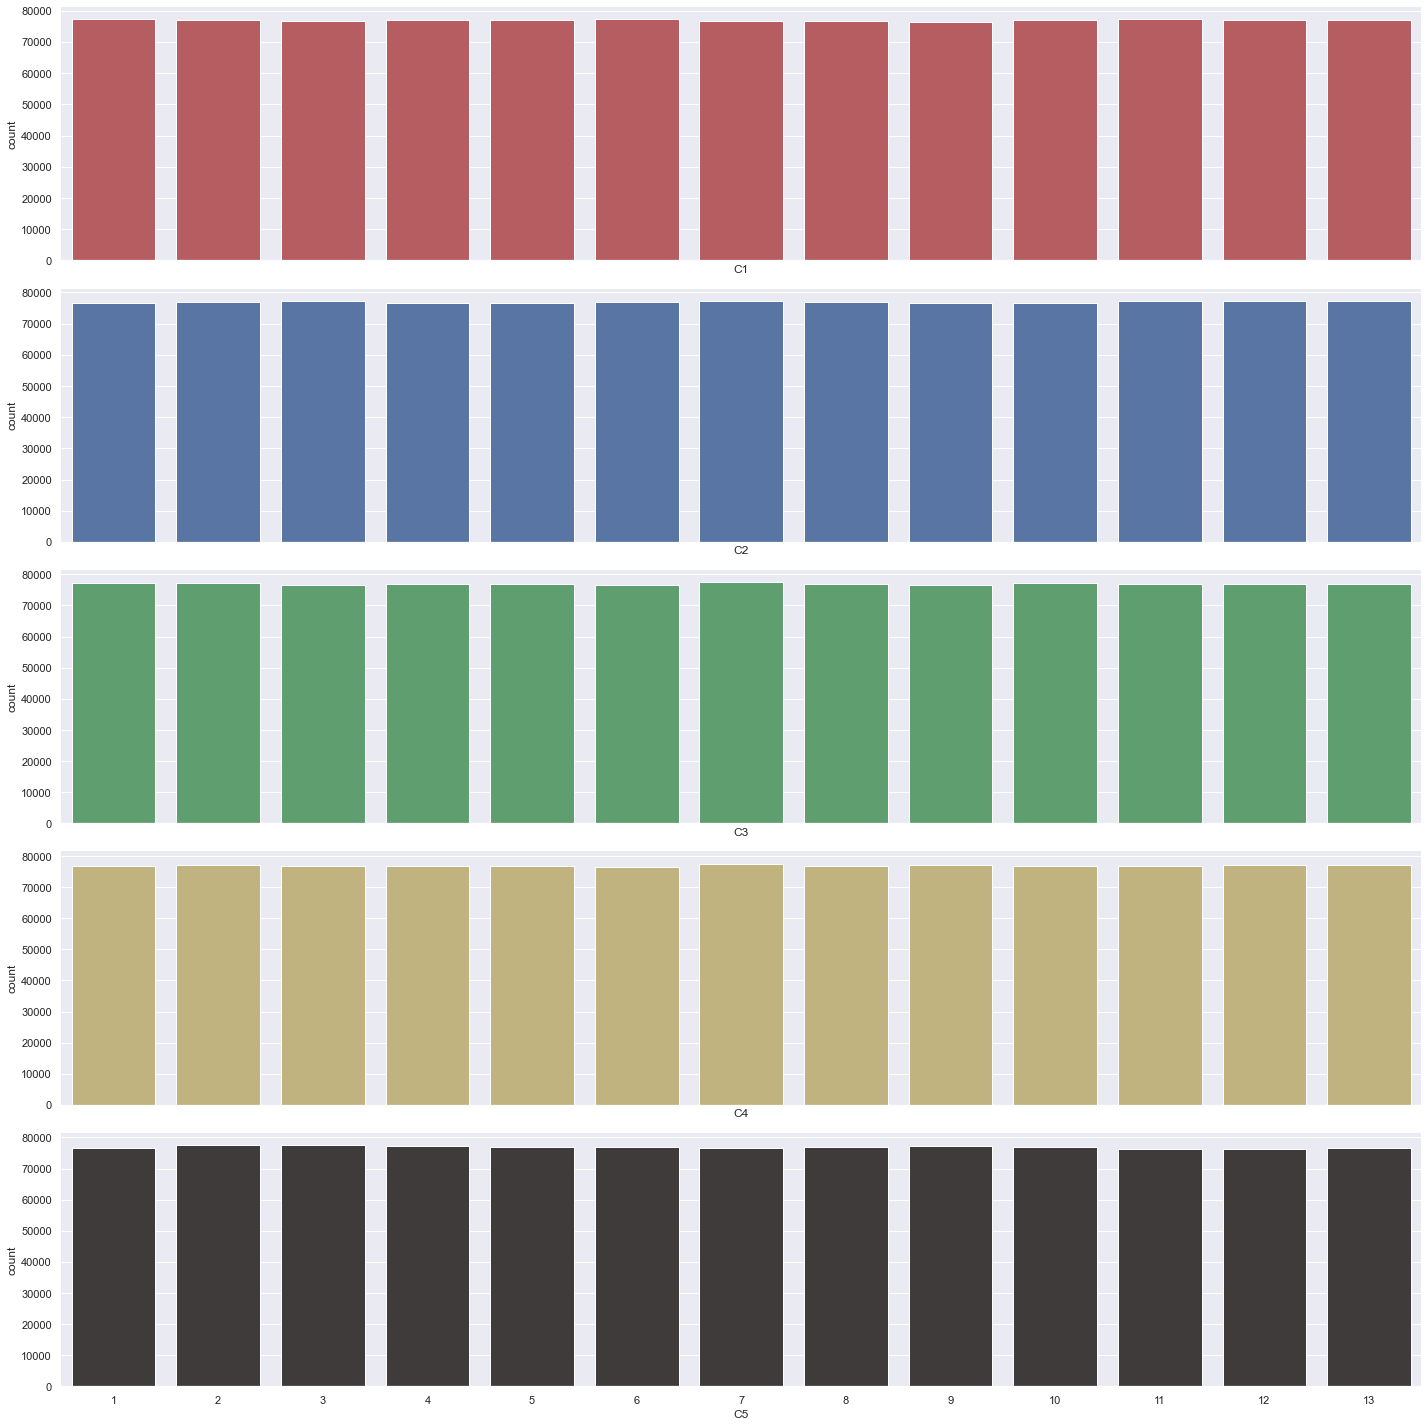

In [24]:
f, ax = plt.subplots(5, 1, figsize=(20, 20), sharex=True)
sns.set()
sns.despine(left=True)

print("X_test amounts of Cardinalities: ")

sns.countplot(X_test['C1'], color='r', ax=ax[0])

sns.countplot(X_test['C2'], color='b', ax=ax[1])

sns.countplot(X_test['C3'], color='g',ax=ax[2])

sns.countplot(X_test['C4'], color='y', ax=ax[3])

sns.countplot(X_test['C5'], color='#403A3A', ax=ax[4])

plt.tight_layout()

Let's see our Correlation Matrix

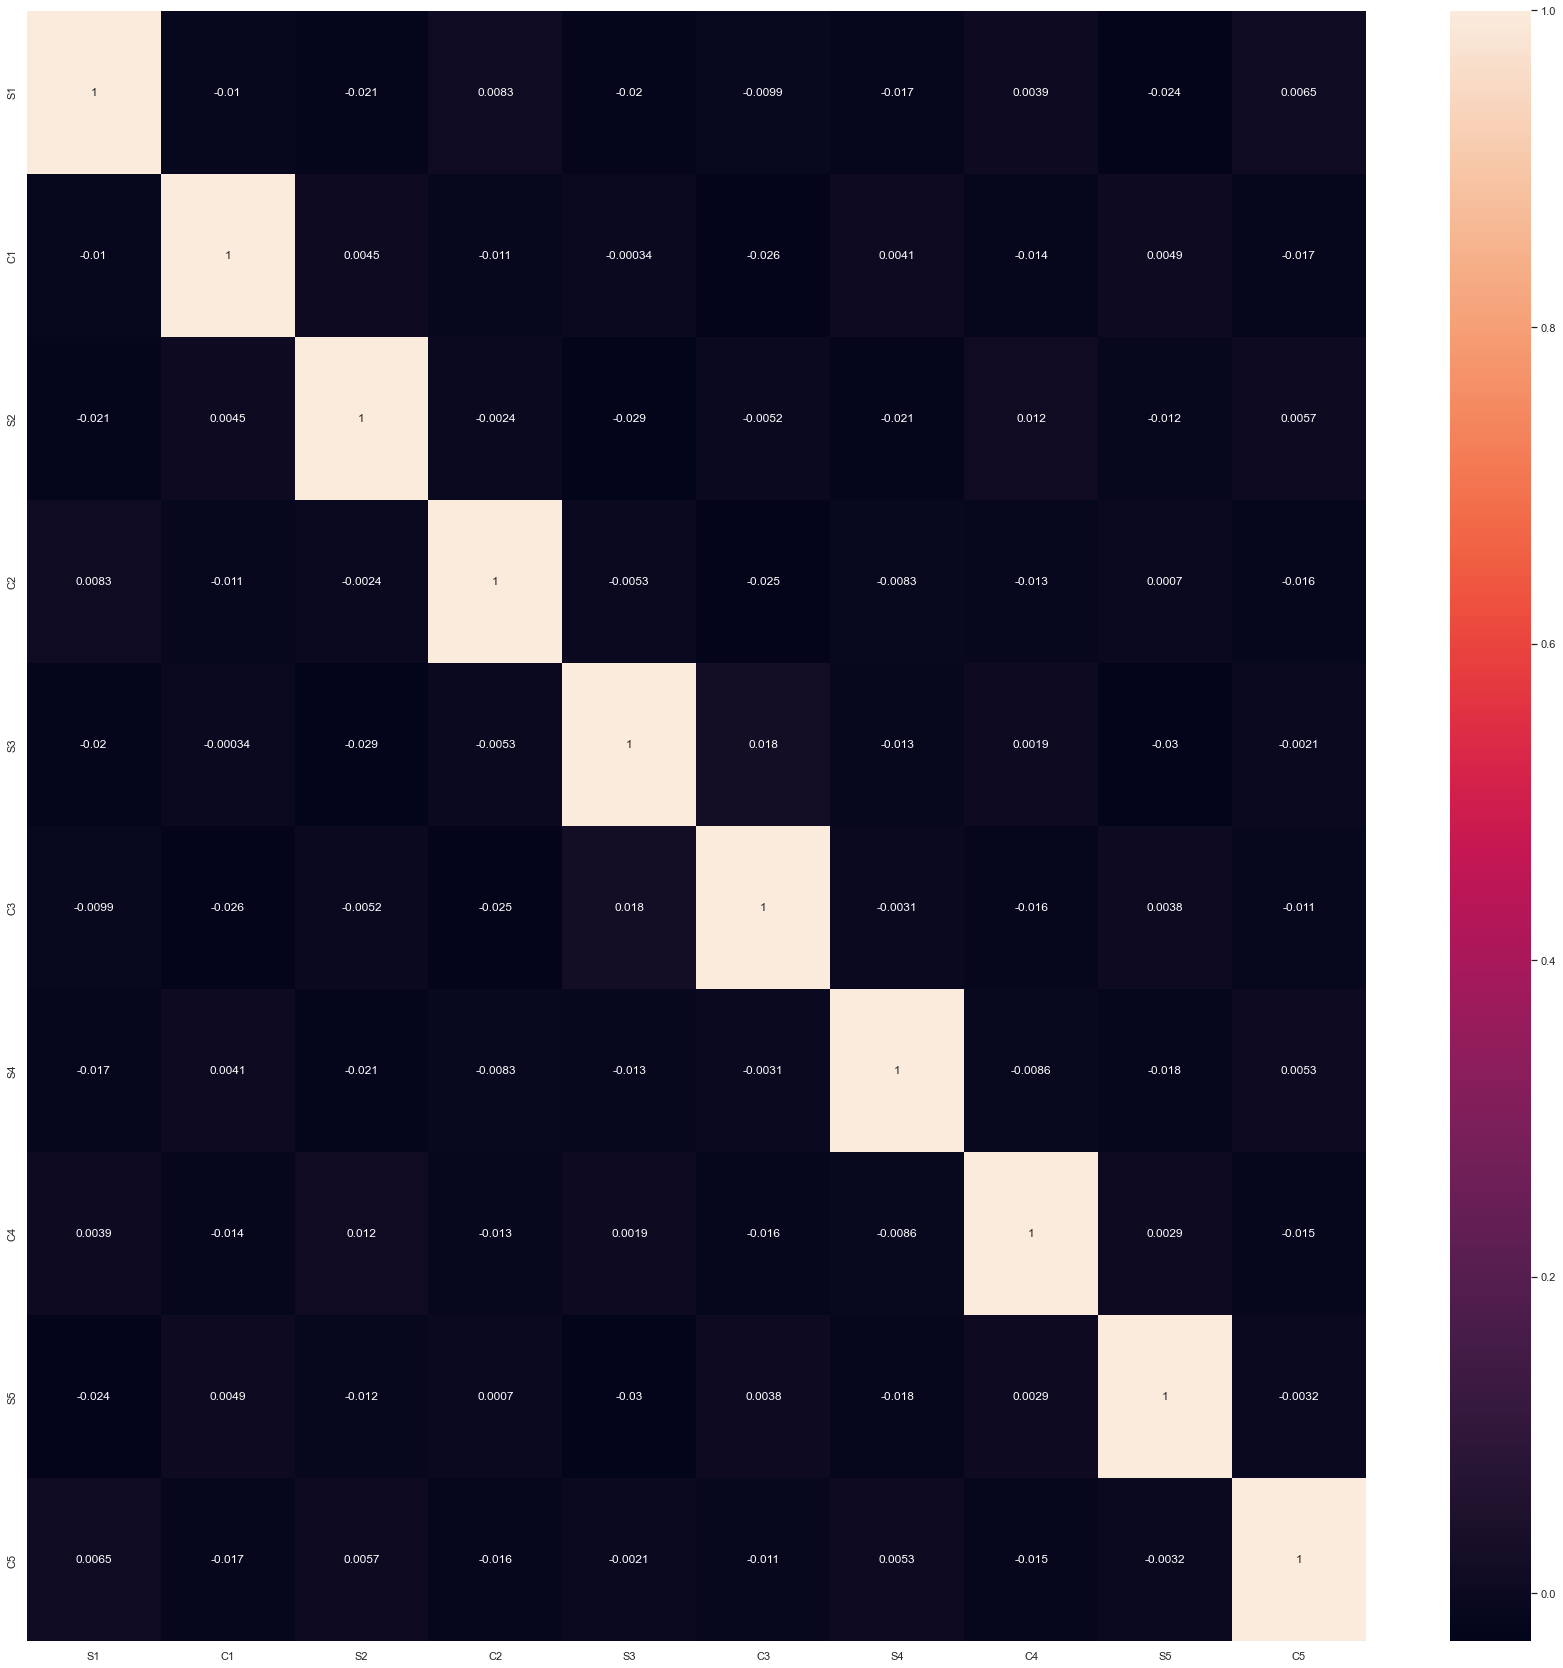

In [25]:
corr_matrix = X_train.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, annot=True)
plt.show()

## 5. Preprocessing and Feature Engineering

- For straights we must show the difference between the cards in an ascending order. But our straight values are not in order.
- For flushes we must show the common occurences in the suits of the hand. Recall: Flush is five cards with the same suit
- For pairs, sets, and quads (2,3, and 4 of a kind) we must show the common occurences in the hand.
- For flushes we must show the common occurences in the suits of the hand.

Let's create some preprocessing functions to help us with these features.

#### 5.1 preprocess_data()
This is the main preprocessing function.\
It first, sorts the suits and cardinalities by themselves and create a new dataframe that we will later on call it preprocessed data.\
This function takes our dataframe and runs it through some functions that we will define later on in the cells of this section.


In [26]:
def preprocess_data(data):
    df = data.copy()
    cards = df[["C1", "C2", "C3", "C4", "C5"]]
    suits = df[["S1", "S2", "S3", "S4", "S5"]]
    cards.values.sort()
    suits.values.sort()
    df[["C1", "C2", "C3", "C4", "C5"]] = cards
    df[["S1", "S2", "S3", "S4", "S5"]] = suits
    df = df[["S1", "C1","S2", "C2","S3", "C3","S4", "C4","S5", "C5"]]
    df = add_counts(df)
    df = add_diffs(df)
    df = add_unique_count(df)
    return df

#### 5.2 add_counts()
In the first part of the function down below, we are trying to see the relationship between the pairs, sets and quads.\
For each card in the hand, a new column is added to the original data frame for the count of each card.\
The same is done for the ralionships of the suit.

In [27]:
def add_counts(df):
    tmp_card = df[["C1", "C2", "C3", "C4", "C5"]]
    tmp_suit = df[["S1", "S2", "S3", "S4", "S5"]]
    #Pairs, sets, and quads. (equal ranks)
    df["cnt_c1"] = tmp_card.apply(lambda c: sum(c==c[0]), axis=1)
    df["cnt_c2"] = tmp_card.apply(lambda c: sum(c==c[1]), axis=1)
    df["cnt_c3"] = tmp_card.apply(lambda c: sum(c==c[2]), axis=1)
    df["cnt_c4"] = tmp_card.apply(lambda c: sum(c==c[3]), axis=1)
    df["cnt_c5"] = tmp_card.apply(lambda c: sum(c==c[4]), axis=1)
    # Flushes (five cards with the same suit)
    df["cnt_s1"] = tmp_suit.apply(lambda s: sum(s==s[0]), axis=1)
    df["cnt_s2"] = tmp_suit.apply(lambda s: sum(s==s[1]), axis=1)
    df["cnt_s3"] = tmp_suit.apply(lambda s: sum(s==s[2]), axis=1)
    df["cnt_s4"] = tmp_suit.apply(lambda s: sum(s==s[3]), axis=1)
    df["cnt_s5"] = tmp_suit.apply(lambda s: sum(s==s[4]), axis=1)
    return df

#### 5.3 add_diffs()
In the first part of the function we calculate the differences between the rank of the cards to determine a possible straight.\
The second part of the function is resembling the add_counts function, it adds up the differences.\
So, if there is a straight the cnt_diff columns should all equal to 4. (except in the case of an ace during a royal straight.)

In [28]:
def add_diffs(df):
    tmp = df
    #if a straight is possible
    df["diff_1"] = tmp["C2"] - tmp["C1"]
    df["diff_2"] = tmp["C3"] - tmp["C2"]
    df["diff_3"] = tmp["C4"] - tmp["C3"]
    df["diff_4"] = tmp["C5"] - tmp["C4"]
    #Counts how many similar differences there are
    tmp_diff = df[["diff_1","diff_2","diff_3","diff_4"]]
    df["cnt_diff1"] = tmp_diff.apply(lambda c: sum(c==c[0]), axis=1)
    df["cnt_diff2"] = tmp_diff.apply(lambda c: sum(c==c[1]), axis=1)
    df["cnt_diff3"] = tmp_diff.apply(lambda c: sum(c==c[2]), axis=1)
    df["cnt_diff4"] = tmp_diff.apply(lambda c: sum(c==c[3]), axis=1)
    return df

#### 5.4 add_unique_count()
This function breaks the given data frame into suits.\
With the help of lambda function it checks how many unique suits are in the hand.\
This helps for checking a flush condition or not.\
A flush will always have a unique count of "1" because all cards must be of the same suit.

In [29]:
def add_unique_count(df):
    tmp_suit = df[["S1", "S2", "S3", "S4", "S5"]]
    df["unique_suit"] = tmp_suit.apply(lambda s: len(np.unique(s)), axis=1)
    return df

In [36]:
#X_train_preprocessed = preprocess_data(X_train)
#X_test_preprocessed = preprocess_data(X_test)
X_train_preprocessed = pickle.load(open("X_train_pre.pickle","rb"))
X_test_preprocessed = pickle.load(open("X_test_pre.pickle", "rb"))

## 6. Data Augmentation Using SMOTE
As I mentioned in the Data Information section, our dataset is highly imbalanced so we need to use SMOTE to oversample some of our data.

In [37]:
counts_of_ranks_train = Counter(sorted(y_train))
counts_of_ranks_train

Counter({0: 12493,
         1: 10599,
         2: 1206,
         3: 513,
         4: 93,
         5: 54,
         6: 36,
         7: 6,
         8: 5,
         9: 4})

The class amount of synthetic sample formula:

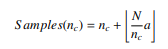

In this part we can't over sample all of the data because it is not necessary and redundant since some classes have a really small amount of combinations.\

For example, let's say there is a class that can maximum have 100 samples (possible combinations), sampling more than 100 will be redundant.\

In this formula, the notations are,
- nc: number of samples of class c from the given dataset
- N: total number of samples in the dataset
- a: adjustable parameter between [0,1] 

The best a value in our case was 0.2 with various experiments.

In [38]:
def samples_func(num_of_c, num_of_all, alfa_val):
    return math.floor((num_of_all / num_of_c) * alfa_val)

This sample_amount() method returns a dictionary keys and values where the key is the class and the values are the amount of samples it should be generated with the synthetic formula 

In [39]:
def sample_amount(data):
    freq_dict = dict()
    
    num_of_samples = 0
    
    for i in range(10):
        freq_dict[str(i)] = data.value_counts()[i]
        num_of_samples += freq_dict[str(i)]
    
    sample_amounts = dict()
    
    for key in freq_dict:
        sample_amounts[key] = samples_func(freq_dict[key], num_of_samples, 0.5)
    
    return sample_amounts

Creating a dictionary (sampling_strategy) to use for Weighted SMOTE (WSMOTE)

In [40]:
sampling_strategy = dict()
print(type(y_train))
i = 0
for key, val in sample_amount(y_train).items():
    sampling_strategy[key] = y_train.value_counts()[i] + val
    i +=1

sampling_strategy

<class 'pandas.core.series.Series'>


{'0': 12494,
 '1': 10600,
 '2': 1216,
 '3': 537,
 '4': 227,
 '5': 285,
 '6': 383,
 '7': 2090,
 '8': 2505,
 '9': 3130}

In [41]:
weighted_sm = SMOTE(k_neighbors=3,random_state=42, sampling_strategy={0:12494, 1:10600, 2:1216, 3:537, 4:227, 5:285, 6:383, 7:2090, 8:2505,9:3130})

X_train_oversampled, y_train_oversampled = weighted_sm.fit_resample(X_train, y_train)

X_train_preprocessed_oversampled, y_train_preprocessed_oversampled = weighted_sm.fit_resample(X_train_preprocessed, y_train)

In [42]:
X_train_oversampled.shape, y_train_oversampled.shape

((33467, 10), (33467,))

In [43]:
X_train_preprocessed_oversampled.shape, y_train_preprocessed_oversampled.shape

((33467, 29), (33467,))

## 7. Model Training 
- XGBoost
- CatBoost
- Neural Network
- RandomForest

Pre-work\
Some utility functions for tranining and evaluating

In [44]:
def conf_matrix(y_true, y_preds):
    cm = confusion_matrix(y_true, y_preds)
    plt.figure(figsize=(20,15))
    sns.heatmap(cm, annot=True, fmt='d')

In [45]:
def show_classification_report(y_test, y_preds):
    print(classification_report(y_test, y_preds))

#### 7.1 XGBoost

In [46]:
xgboost = XGBClassifier()

In [49]:
xgboost.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

##### 7.1.1 Training with default model of XGBoost

###### 7.1.1.1 Raw Data

In [47]:
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [50]:
y_preds = xgboost.predict(X_test)

In [51]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84    501208
           1       0.72      0.69      0.70    422498
           2       0.33      0.05      0.09     47622
           3       0.61      0.07      0.13     21121
           4       0.15      0.02      0.03      3885
           5       0.82      0.06      0.11      1996
           6       0.15      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.75    999999
   macro avg       0.36      0.18      0.19    999999
weighted avg       0.72      0.75      0.72    999999



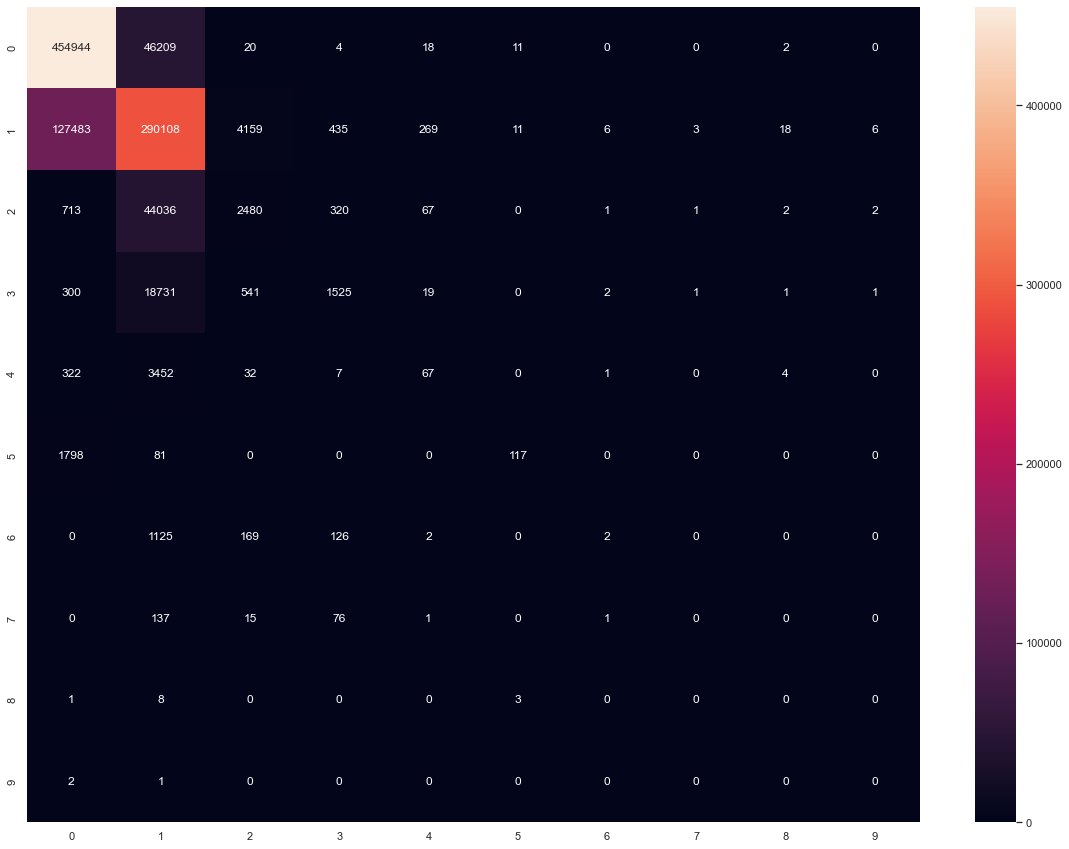

In [52]:
conf_matrix(y_test, y_preds)

###### 7.1.1.2 Preprocessed and Sampled Data

In [53]:
xgboost.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [55]:
y_preds = xgboost.predict(X_test_preprocessed)

In [56]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      0.97      0.98      3885
           5       1.00      1.00      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.13      1.00      0.22        12
           9       0.33      1.00      0.50         3

    accuracy                           1.00    999999
   macro avg       0.85      1.00      0.87    999999
weighted avg       1.00      1.00      1.00    999999



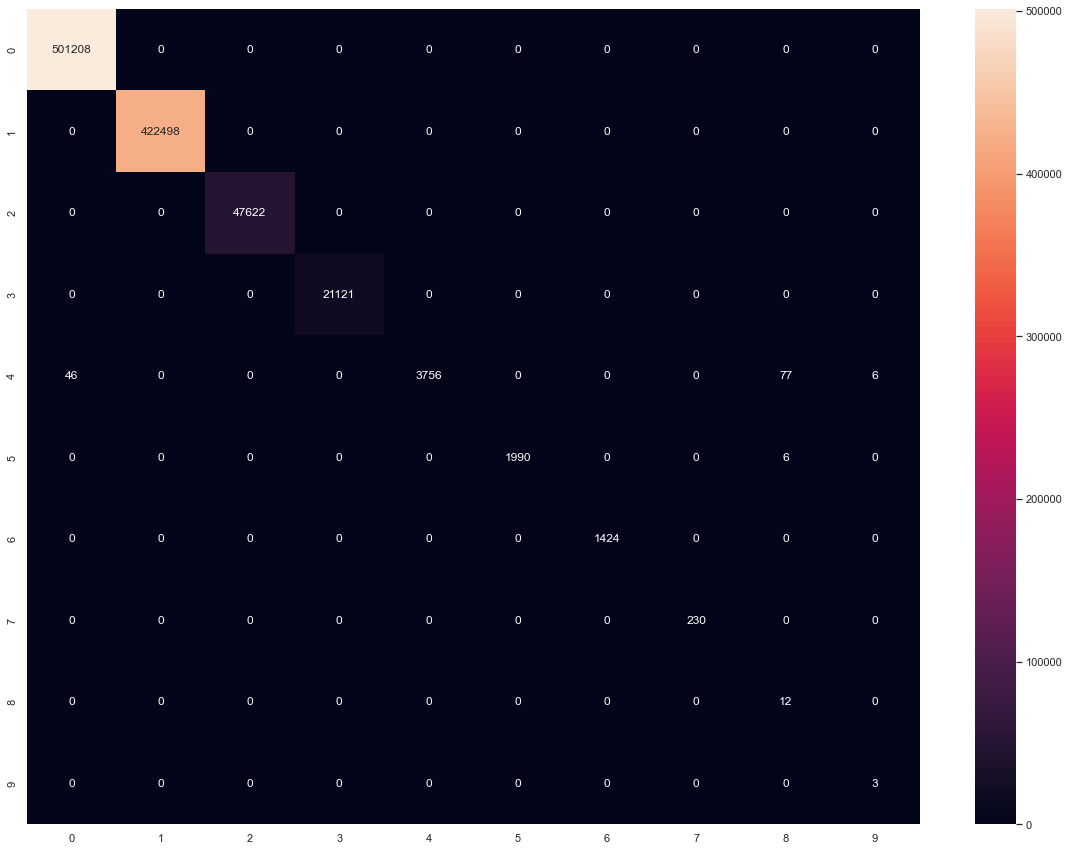

In [57]:
conf_matrix(y_test, y_preds)

##### 7.1.2 Hyperparameter Tunning of XGBoost and Training with Hyparameter tuned Model

In [58]:
parameters = { 
        'n_estimators': [10,50], 
        'max_depth': [10], 
        'learning_rate': [0.1, 0.01, 0.001], 
        "colsample_bytree": [0.3, 0.5],
        "reg_alpha": [0, 1, 5],
        "reg_lambda": [0, 1, 5]
}

xgboost_cv = GridSearchCV(xgboost, parameters, cv = 5, n_jobs = -1, verbose = 2)

###### 7.1.2.1 Raw Data

In [59]:
xgboost_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012...
                                     max_delta_step=0, max_depth=6,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5],
                         'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [10],
                         'n_estimators': [10, 50], 'reg_alpha': [0, 1, 5],
                         'reg_lambda': [0, 1, 5]},
             verbose=2)

In [61]:
xgboost_cv.best_estimator_.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 10,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [62]:
y_preds = xgboost_cv.predict(X_test)

In [63]:
show_classification_report(y_test,y_preds)

              precision    recall  f1-score   support

           0       0.70      0.89      0.78    501208
           1       0.66      0.57      0.61    422498
           2       0.38      0.00      0.00     47622
           3       0.79      0.00      0.00     21121
           4       0.00      0.00      0.00      3885
           5       1.00      0.00      0.00      1996
           6       0.00      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.69    999999
   macro avg       0.35      0.15      0.14    999999
weighted avg       0.67      0.69      0.65    999999



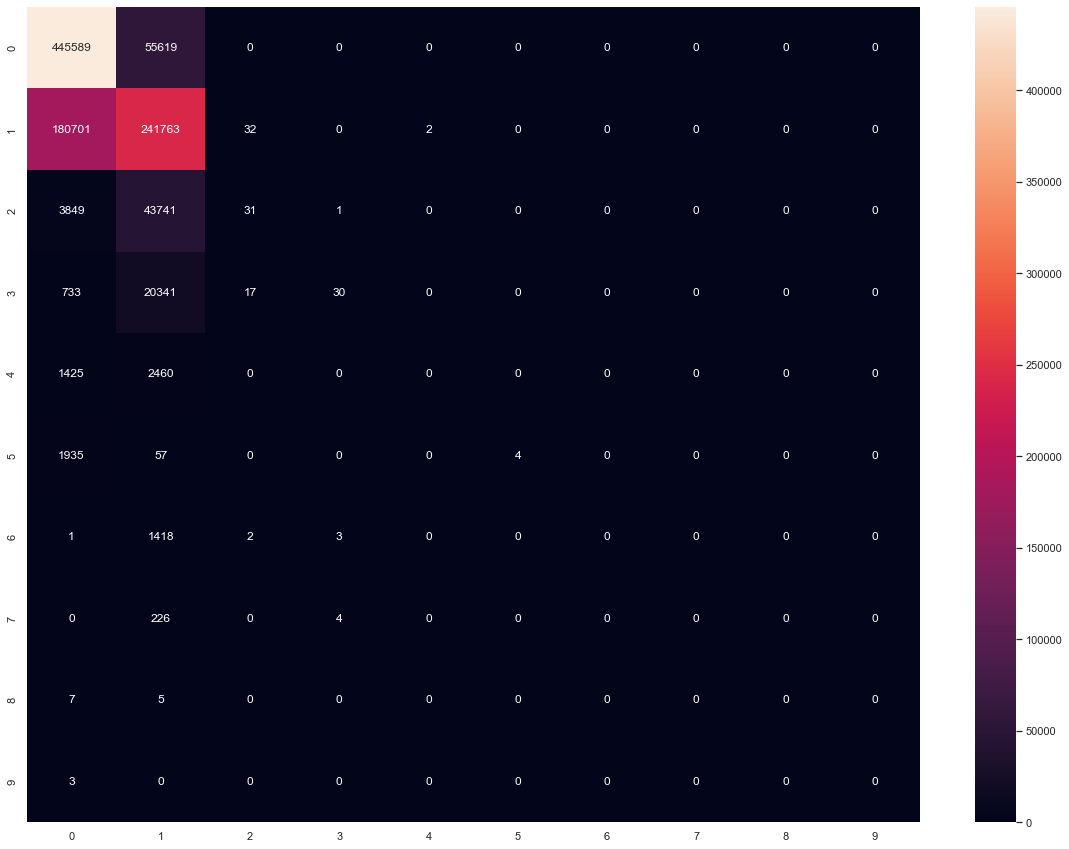

In [64]:
conf_matrix(y_test, y_preds)

###### 7.1.2.2 Preprocessed and Sampled Data

In [65]:
xgboost_cv.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=1,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012...
                                     max_delta_step=0, max_depth=6,
                                     max_leaves=0, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='multi:softprob',
                                     predictor='auto', ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.3, 0.5],
                         'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [10],
                         'n_estimators': [10, 50], 'reg_alpha': [0, 1, 5],
                         'reg_lambda': [0, 1, 5]},
             verbose=2)

In [66]:
xgboost_cv.best_estimator_.get_params()

{'objective': 'multi:softprob',
 'use_label_encoder': None,
 'base_score': 0.5,
 'booster': 'gbtree',
 'callbacks': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'importance_type': None,
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_bin': 256,
 'max_cat_threshold': 64,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 10,
 'max_leaves': 0,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 50,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'sampling_method': 'uniform',
 'scale_pos_weight': None,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [67]:
y_preds = xgboost_cv.predict(X_test_preprocessed)

In [68]:
show_classification_report(y_test,y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      0.99      0.99      3885
           5       1.00      0.99      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.92      1.00      0.96        12
           9       0.17      1.00      0.29         3

    accuracy                           1.00    999999
   macro avg       0.91      1.00      0.92    999999
weighted avg       1.00      1.00      1.00    999999



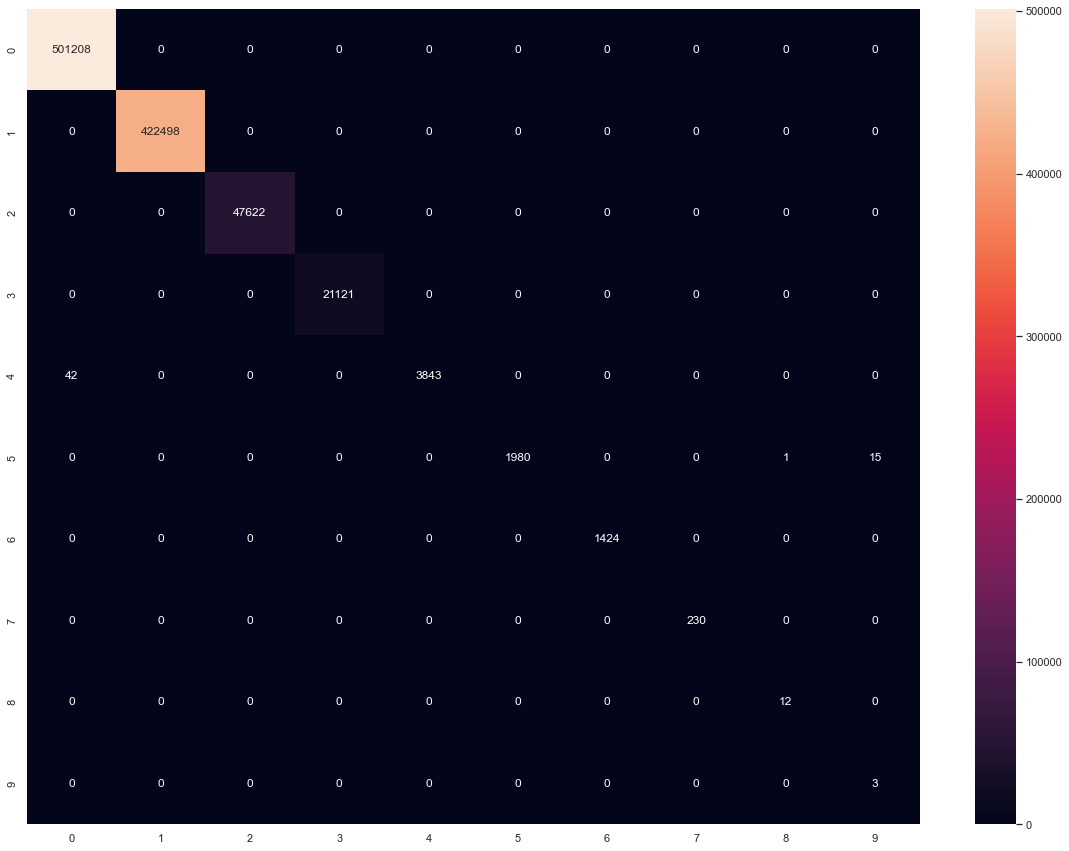

In [69]:
conf_matrix(y_test, y_preds)

#### 7.2 CatBoost

In [70]:
CBC = CatBoostClassifier()

##### 7.2.1 Training with default model of CatBoost

###### 7.2.1.1 Raw Data

In [72]:
CBC.fit(X_train, y_train)

Learning rate set to 0.093245
0:	learn: 2.0189214	total: 173ms	remaining: 2m 53s
1:	learn: 1.8345915	total: 185ms	remaining: 1m 32s
2:	learn: 1.6979551	total: 197ms	remaining: 1m 5s
3:	learn: 1.5906218	total: 208ms	remaining: 51.9s
4:	learn: 1.5039110	total: 219ms	remaining: 43.6s
5:	learn: 1.4320706	total: 230ms	remaining: 38.2s
6:	learn: 1.3739783	total: 241ms	remaining: 34.2s
7:	learn: 1.3232265	total: 252ms	remaining: 31.2s
8:	learn: 1.2793968	total: 263ms	remaining: 28.9s
9:	learn: 1.2419376	total: 273ms	remaining: 27s
10:	learn: 1.2091684	total: 283ms	remaining: 25.5s
11:	learn: 1.1811168	total: 290ms	remaining: 23.8s
12:	learn: 1.1569567	total: 299ms	remaining: 22.7s
13:	learn: 1.1357263	total: 309ms	remaining: 21.8s
14:	learn: 1.1132156	total: 319ms	remaining: 21s
15:	learn: 1.0964446	total: 330ms	remaining: 20.3s
16:	learn: 1.0777457	total: 340ms	remaining: 19.6s
17:	learn: 1.0598375	total: 350ms	remaining: 19.1s
18:	learn: 1.0442576	total: 360ms	remaining: 18.6s
19:	learn: 1.

161:	learn: 0.7349874	total: 1.72s	remaining: 8.87s
162:	learn: 0.7344867	total: 1.72s	remaining: 8.86s
163:	learn: 0.7333991	total: 1.73s	remaining: 8.84s
164:	learn: 0.7325931	total: 1.74s	remaining: 8.82s
165:	learn: 0.7320671	total: 1.75s	remaining: 8.8s
166:	learn: 0.7303281	total: 1.76s	remaining: 8.79s
167:	learn: 0.7299279	total: 1.77s	remaining: 8.77s
168:	learn: 0.7292520	total: 1.78s	remaining: 8.76s
169:	learn: 0.7287740	total: 1.79s	remaining: 8.74s
170:	learn: 0.7282608	total: 1.8s	remaining: 8.73s
171:	learn: 0.7275294	total: 1.81s	remaining: 8.71s
172:	learn: 0.7270620	total: 1.82s	remaining: 8.69s
173:	learn: 0.7261509	total: 1.83s	remaining: 8.68s
174:	learn: 0.7254700	total: 1.84s	remaining: 8.66s
175:	learn: 0.7246654	total: 1.85s	remaining: 8.64s
176:	learn: 0.7241867	total: 1.85s	remaining: 8.63s
177:	learn: 0.7234244	total: 1.86s	remaining: 8.61s
178:	learn: 0.7222768	total: 1.87s	remaining: 8.6s
179:	learn: 0.7216162	total: 1.88s	remaining: 8.58s
180:	learn: 0.7

320:	learn: 0.6429132	total: 3.23s	remaining: 6.82s
321:	learn: 0.6426590	total: 3.23s	remaining: 6.81s
322:	learn: 0.6423971	total: 3.24s	remaining: 6.8s
323:	learn: 0.6420947	total: 3.25s	remaining: 6.79s
324:	learn: 0.6408670	total: 3.26s	remaining: 6.77s
325:	learn: 0.6404780	total: 3.27s	remaining: 6.76s
326:	learn: 0.6400383	total: 3.28s	remaining: 6.75s
327:	learn: 0.6388236	total: 3.29s	remaining: 6.74s
328:	learn: 0.6384422	total: 3.3s	remaining: 6.73s
329:	learn: 0.6381745	total: 3.31s	remaining: 6.71s
330:	learn: 0.6378094	total: 3.32s	remaining: 6.7s
331:	learn: 0.6373103	total: 3.33s	remaining: 6.69s
332:	learn: 0.6364975	total: 3.33s	remaining: 6.68s
333:	learn: 0.6361937	total: 3.34s	remaining: 6.67s
334:	learn: 0.6354485	total: 3.35s	remaining: 6.66s
335:	learn: 0.6350922	total: 3.36s	remaining: 6.64s
336:	learn: 0.6348037	total: 3.37s	remaining: 6.63s
337:	learn: 0.6340325	total: 3.38s	remaining: 6.62s
338:	learn: 0.6336841	total: 3.39s	remaining: 6.61s
339:	learn: 0.6

486:	learn: 0.5704326	total: 4.75s	remaining: 5s
487:	learn: 0.5701761	total: 4.76s	remaining: 4.99s
488:	learn: 0.5698744	total: 4.77s	remaining: 4.98s
489:	learn: 0.5696417	total: 4.78s	remaining: 4.97s
490:	learn: 0.5687966	total: 4.79s	remaining: 4.96s
491:	learn: 0.5684946	total: 4.8s	remaining: 4.95s
492:	learn: 0.5682505	total: 4.81s	remaining: 4.94s
493:	learn: 0.5679321	total: 4.82s	remaining: 4.93s
494:	learn: 0.5676615	total: 4.83s	remaining: 4.92s
495:	learn: 0.5674546	total: 4.83s	remaining: 4.91s
496:	learn: 0.5672551	total: 4.84s	remaining: 4.9s
497:	learn: 0.5666644	total: 4.85s	remaining: 4.89s
498:	learn: 0.5664423	total: 4.86s	remaining: 4.88s
499:	learn: 0.5661159	total: 4.87s	remaining: 4.87s
500:	learn: 0.5657596	total: 4.88s	remaining: 4.86s
501:	learn: 0.5655185	total: 4.89s	remaining: 4.85s
502:	learn: 0.5652433	total: 4.9s	remaining: 4.84s
503:	learn: 0.5648735	total: 4.91s	remaining: 4.83s
504:	learn: 0.5646605	total: 4.92s	remaining: 4.82s
505:	learn: 0.5643

665:	learn: 0.5083708	total: 6.45s	remaining: 3.23s
666:	learn: 0.5081140	total: 6.46s	remaining: 3.22s
667:	learn: 0.5078389	total: 6.46s	remaining: 3.21s
668:	learn: 0.5073470	total: 6.47s	remaining: 3.2s
669:	learn: 0.5071040	total: 6.48s	remaining: 3.19s
670:	learn: 0.5066343	total: 6.49s	remaining: 3.18s
671:	learn: 0.5064204	total: 6.5s	remaining: 3.17s
672:	learn: 0.5062164	total: 6.51s	remaining: 3.16s
673:	learn: 0.5059913	total: 6.52s	remaining: 3.15s
674:	learn: 0.5053931	total: 6.53s	remaining: 3.14s
675:	learn: 0.5051835	total: 6.54s	remaining: 3.13s
676:	learn: 0.5048430	total: 6.55s	remaining: 3.12s
677:	learn: 0.5044755	total: 6.56s	remaining: 3.11s
678:	learn: 0.5042933	total: 6.57s	remaining: 3.1s
679:	learn: 0.5041061	total: 6.57s	remaining: 3.09s
680:	learn: 0.5037440	total: 6.58s	remaining: 3.08s
681:	learn: 0.5035557	total: 6.59s	remaining: 3.07s
682:	learn: 0.5033153	total: 6.6s	remaining: 3.06s
683:	learn: 0.5029281	total: 6.61s	remaining: 3.05s
684:	learn: 0.50

834:	learn: 0.4614088	total: 7.98s	remaining: 1.58s
835:	learn: 0.4612868	total: 7.99s	remaining: 1.57s
836:	learn: 0.4611687	total: 8s	remaining: 1.56s
837:	learn: 0.4610279	total: 8.01s	remaining: 1.55s
838:	learn: 0.4608713	total: 8.02s	remaining: 1.54s
839:	learn: 0.4606019	total: 8.03s	remaining: 1.53s
840:	learn: 0.4604310	total: 8.04s	remaining: 1.52s
841:	learn: 0.4602392	total: 8.04s	remaining: 1.51s
842:	learn: 0.4600839	total: 8.05s	remaining: 1.5s
843:	learn: 0.4596405	total: 8.06s	remaining: 1.49s
844:	learn: 0.4587410	total: 8.07s	remaining: 1.48s
845:	learn: 0.4586065	total: 8.08s	remaining: 1.47s
846:	learn: 0.4583914	total: 8.09s	remaining: 1.46s
847:	learn: 0.4582675	total: 8.1s	remaining: 1.45s
848:	learn: 0.4581261	total: 8.11s	remaining: 1.44s
849:	learn: 0.4579114	total: 8.12s	remaining: 1.43s
850:	learn: 0.4577597	total: 8.13s	remaining: 1.42s
851:	learn: 0.4574903	total: 8.14s	remaining: 1.41s
852:	learn: 0.4572979	total: 8.14s	remaining: 1.4s
853:	learn: 0.4565

In [73]:
y_preds = CBC.predict(X_test)

In [74]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84    501208
           1       0.72      0.70      0.71    422498
           2       0.57      0.08      0.14     47622
           3       0.67      0.10      0.18     21121
           4       0.25      0.02      0.03      3885
           5       0.83      0.04      0.07      1996
           6       0.67      0.00      0.01      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.76    999999
   macro avg       0.45      0.18      0.20    999999
weighted avg       0.74      0.76      0.73    999999



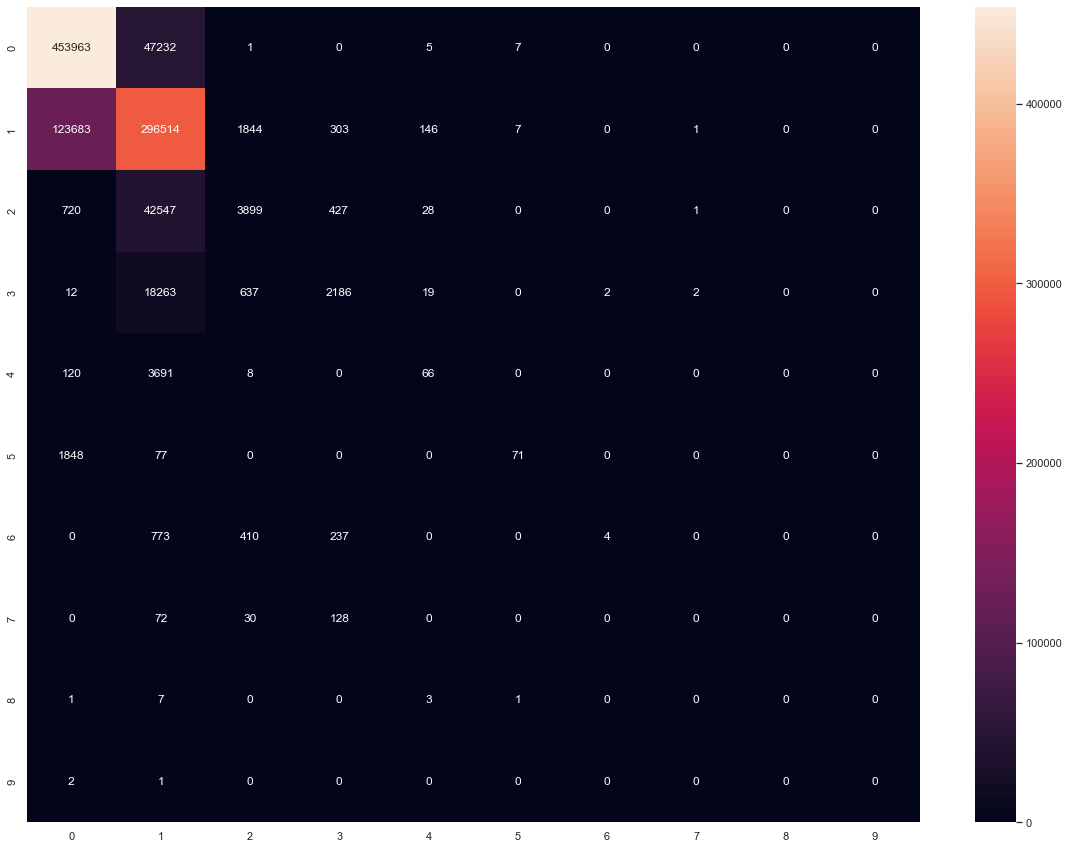

In [75]:
conf_matrix(y_test, y_preds)

###### 7.2.1.2 Preprocessed and Sampled Data

In [76]:
CBC.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

Learning rate set to 0.094641
0:	learn: 1.5427238	total: 22.2ms	remaining: 22.1s
1:	learn: 1.2354585	total: 43.1ms	remaining: 21.5s
2:	learn: 1.0208434	total: 63.8ms	remaining: 21.2s
3:	learn: 0.8705787	total: 84.6ms	remaining: 21.1s
4:	learn: 0.7497599	total: 105ms	remaining: 20.8s
5:	learn: 0.6529577	total: 125ms	remaining: 20.7s
6:	learn: 0.5749761	total: 146ms	remaining: 20.7s
7:	learn: 0.5080228	total: 165ms	remaining: 20.5s
8:	learn: 0.4516955	total: 185ms	remaining: 20.4s
9:	learn: 0.4020470	total: 207ms	remaining: 20.5s
10:	learn: 0.3599910	total: 227ms	remaining: 20.4s
11:	learn: 0.3231782	total: 246ms	remaining: 20.3s
12:	learn: 0.2903859	total: 265ms	remaining: 20.2s
13:	learn: 0.2617741	total: 285ms	remaining: 20.1s
14:	learn: 0.2361688	total: 305ms	remaining: 20s
15:	learn: 0.2134634	total: 324ms	remaining: 20s
16:	learn: 0.1933418	total: 344ms	remaining: 19.9s
17:	learn: 0.1748262	total: 363ms	remaining: 19.8s
18:	learn: 0.1586342	total: 383ms	remaining: 19.8s
19:	learn: 

169:	learn: 0.0006337	total: 3.36s	remaining: 16.4s
170:	learn: 0.0006316	total: 3.38s	remaining: 16.4s
171:	learn: 0.0006311	total: 3.4s	remaining: 16.3s
172:	learn: 0.0006261	total: 3.42s	remaining: 16.3s
173:	learn: 0.0006234	total: 3.44s	remaining: 16.3s
174:	learn: 0.0006153	total: 3.46s	remaining: 16.3s
175:	learn: 0.0006130	total: 3.48s	remaining: 16.3s
176:	learn: 0.0006104	total: 3.49s	remaining: 16.3s
177:	learn: 0.0006100	total: 3.51s	remaining: 16.2s
178:	learn: 0.0006096	total: 3.53s	remaining: 16.2s
179:	learn: 0.0006073	total: 3.55s	remaining: 16.2s
180:	learn: 0.0006035	total: 3.57s	remaining: 16.1s
181:	learn: 0.0006031	total: 3.58s	remaining: 16.1s
182:	learn: 0.0006017	total: 3.6s	remaining: 16.1s
183:	learn: 0.0006014	total: 3.61s	remaining: 16s
184:	learn: 0.0006012	total: 3.62s	remaining: 16s
185:	learn: 0.0006009	total: 3.64s	remaining: 15.9s
186:	learn: 0.0005878	total: 3.66s	remaining: 15.9s
187:	learn: 0.0005810	total: 3.68s	remaining: 15.9s
188:	learn: 0.0005

331:	learn: 0.0002983	total: 6.21s	remaining: 12.5s
332:	learn: 0.0002983	total: 6.23s	remaining: 12.5s
333:	learn: 0.0002983	total: 6.25s	remaining: 12.5s
334:	learn: 0.0002977	total: 6.27s	remaining: 12.4s
335:	learn: 0.0002976	total: 6.28s	remaining: 12.4s
336:	learn: 0.0002976	total: 6.3s	remaining: 12.4s
337:	learn: 0.0002976	total: 6.31s	remaining: 12.4s
338:	learn: 0.0002956	total: 6.33s	remaining: 12.3s
339:	learn: 0.0002956	total: 6.34s	remaining: 12.3s
340:	learn: 0.0002956	total: 6.36s	remaining: 12.3s
341:	learn: 0.0002947	total: 6.38s	remaining: 12.3s
342:	learn: 0.0002947	total: 6.38s	remaining: 12.2s
343:	learn: 0.0002940	total: 6.4s	remaining: 12.2s
344:	learn: 0.0002907	total: 6.42s	remaining: 12.2s
345:	learn: 0.0002907	total: 6.43s	remaining: 12.2s
346:	learn: 0.0002907	total: 6.45s	remaining: 12.1s
347:	learn: 0.0002907	total: 6.47s	remaining: 12.1s
348:	learn: 0.0002875	total: 6.49s	remaining: 12.1s
349:	learn: 0.0002875	total: 6.5s	remaining: 12.1s
350:	learn: 0.0

495:	learn: 0.0002143	total: 8.89s	remaining: 9.03s
496:	learn: 0.0002143	total: 8.9s	remaining: 9s
497:	learn: 0.0002128	total: 8.92s	remaining: 8.99s
498:	learn: 0.0002118	total: 8.94s	remaining: 8.97s
499:	learn: 0.0002118	total: 8.96s	remaining: 8.96s
500:	learn: 0.0002118	total: 8.97s	remaining: 8.94s
501:	learn: 0.0002111	total: 8.99s	remaining: 8.92s
502:	learn: 0.0002094	total: 9.02s	remaining: 8.91s
503:	learn: 0.0002078	total: 9.04s	remaining: 8.89s
504:	learn: 0.0002068	total: 9.06s	remaining: 8.88s
505:	learn: 0.0002068	total: 9.07s	remaining: 8.85s
506:	learn: 0.0002068	total: 9.09s	remaining: 8.84s
507:	learn: 0.0002068	total: 9.1s	remaining: 8.81s
508:	learn: 0.0002068	total: 9.11s	remaining: 8.79s
509:	learn: 0.0002064	total: 9.13s	remaining: 8.77s
510:	learn: 0.0002057	total: 9.15s	remaining: 8.76s
511:	learn: 0.0002050	total: 9.17s	remaining: 8.74s
512:	learn: 0.0002036	total: 9.19s	remaining: 8.72s
513:	learn: 0.0002035	total: 9.21s	remaining: 8.7s
514:	learn: 0.0002

654:	learn: 0.0001672	total: 11.5s	remaining: 6.08s
655:	learn: 0.0001669	total: 11.6s	remaining: 6.07s
656:	learn: 0.0001669	total: 11.6s	remaining: 6.05s
657:	learn: 0.0001663	total: 11.6s	remaining: 6.03s
658:	learn: 0.0001663	total: 11.6s	remaining: 6.01s
659:	learn: 0.0001660	total: 11.6s	remaining: 6s
660:	learn: 0.0001658	total: 11.7s	remaining: 5.99s
661:	learn: 0.0001655	total: 11.7s	remaining: 5.97s
662:	learn: 0.0001651	total: 11.7s	remaining: 5.96s
663:	learn: 0.0001651	total: 11.7s	remaining: 5.94s
664:	learn: 0.0001651	total: 11.8s	remaining: 5.92s
665:	learn: 0.0001651	total: 11.8s	remaining: 5.9s
666:	learn: 0.0001651	total: 11.8s	remaining: 5.89s
667:	learn: 0.0001651	total: 11.8s	remaining: 5.87s
668:	learn: 0.0001651	total: 11.8s	remaining: 5.85s
669:	learn: 0.0001640	total: 11.8s	remaining: 5.83s
670:	learn: 0.0001632	total: 11.9s	remaining: 5.82s
671:	learn: 0.0001632	total: 11.9s	remaining: 5.8s
672:	learn: 0.0001629	total: 11.9s	remaining: 5.79s
673:	learn: 0.000

817:	learn: 0.0001356	total: 14.4s	remaining: 3.2s
818:	learn: 0.0001356	total: 14.4s	remaining: 3.18s
819:	learn: 0.0001356	total: 14.4s	remaining: 3.16s
820:	learn: 0.0001354	total: 14.4s	remaining: 3.15s
821:	learn: 0.0001354	total: 14.4s	remaining: 3.13s
822:	learn: 0.0001354	total: 14.5s	remaining: 3.11s
823:	learn: 0.0001354	total: 14.5s	remaining: 3.09s
824:	learn: 0.0001354	total: 14.5s	remaining: 3.07s
825:	learn: 0.0001354	total: 14.5s	remaining: 3.06s
826:	learn: 0.0001354	total: 14.5s	remaining: 3.04s
827:	learn: 0.0001354	total: 14.5s	remaining: 3.02s
828:	learn: 0.0001352	total: 14.6s	remaining: 3s
829:	learn: 0.0001352	total: 14.6s	remaining: 2.98s
830:	learn: 0.0001349	total: 14.6s	remaining: 2.97s
831:	learn: 0.0001349	total: 14.6s	remaining: 2.95s
832:	learn: 0.0001349	total: 14.6s	remaining: 2.93s
833:	learn: 0.0001346	total: 14.6s	remaining: 2.91s
834:	learn: 0.0001346	total: 14.6s	remaining: 2.89s
835:	learn: 0.0001346	total: 14.7s	remaining: 2.88s
836:	learn: 0.00

988:	learn: 0.0001134	total: 17.3s	remaining: 192ms
989:	learn: 0.0001132	total: 17.3s	remaining: 175ms
990:	learn: 0.0001132	total: 17.3s	remaining: 157ms
991:	learn: 0.0001132	total: 17.3s	remaining: 140ms
992:	learn: 0.0001128	total: 17.3s	remaining: 122ms
993:	learn: 0.0001128	total: 17.4s	remaining: 105ms
994:	learn: 0.0001128	total: 17.4s	remaining: 87.2ms
995:	learn: 0.0001128	total: 17.4s	remaining: 69.8ms
996:	learn: 0.0001121	total: 17.4s	remaining: 52.3ms
997:	learn: 0.0001121	total: 17.4s	remaining: 34.9ms
998:	learn: 0.0001121	total: 17.4s	remaining: 17.4ms
999:	learn: 0.0001121	total: 17.4s	remaining: 0us


In [77]:
y_preds = CBC.predict(X_test_preprocessed)

In [78]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      1.00      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.92      1.00      0.96        12
           9       0.33      1.00      0.50         3

    accuracy                           1.00    999999
   macro avg       0.93      1.00      0.95    999999
weighted avg       1.00      1.00      1.00    999999



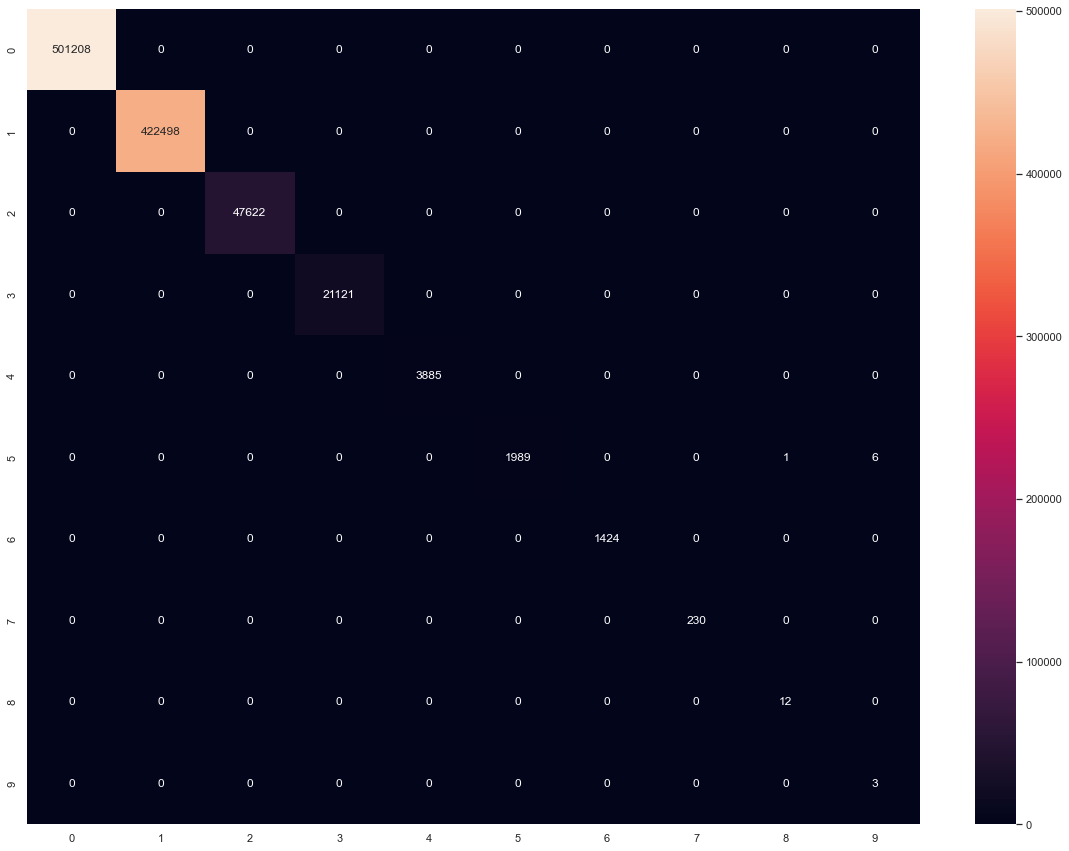

In [79]:
conf_matrix(y_test, y_preds)

##### 7.2.2 Hyperparameter Tunning of CatBoost and Training with Hyparameter tuned Model

In [82]:
parameters = {
    'depth': [4, 5, 8,10],
    'learning_rate': [0.01, 0.02, 0.03],
    'iterations': [10, 20, 50, 100]
}

catboost_cv = GridSearchCV(CBC, parameters, cv = 5, n_jobs = -1, verbose = 2)

###### 7.2.2.1 Raw Data

In [83]:
catboost_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0:	learn: 2.2152777	total: 18.9ms	remaining: 1.87s
1:	learn: 2.1344077	total: 36.9ms	remaining: 1.81s
2:	learn: 2.0649804	total: 54.4ms	remaining: 1.76s
3:	learn: 2.0010670	total: 71.6ms	remaining: 1.72s
4:	learn: 1.9387509	total: 80.2ms	remaining: 1.52s
5:	learn: 1.8846144	total: 95.6ms	remaining: 1.5s
6:	learn: 1.8351453	total: 111ms	remaining: 1.47s
7:	learn: 1.7921020	total: 128ms	remaining: 1.47s
8:	learn: 1.7524593	total: 144ms	remaining: 1.46s
9:	learn: 1.7116582	total: 151ms	remaining: 1.36s
10:	learn: 1.6767481	total: 167ms	remaining: 1.35s
11:	learn: 1.6438074	total: 183ms	remaining: 1.34s
12:	learn: 1.6118194	total: 199ms	remaining: 1.33s
13:	learn: 1.5814059	total: 215ms	remaining: 1.32s
14:	learn: 1.5541708	total: 232ms	remaining: 1.31s
15:	learn: 1.5268045	total: 240ms	remaining: 1.26s
16:	learn: 1.5029070	total: 256ms	remaining: 1.25s
17:	learn: 1.4787908	total: 283ms	remaining: 1.29s
18:	learn: 1.4571238	tota

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000024009906E80>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 8, 10],
                         'iterations': [10, 20, 50, 100],
                         'learning_rate': [0.01, 0.02, 0.03]},
             verbose=2)

In [85]:
catboost_cv.best_estimator_.get_params()

{'iterations': 100, 'learning_rate': 0.03, 'depth': 8}

In [86]:
y_preds = catboost_cv.predict(X_test)

In [87]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.61      0.87      0.72    501208
           1       0.60      0.40      0.48    422498
           2       0.00      0.00      0.00     47622
           3       0.00      0.00      0.00     21121
           4       0.00      0.00      0.00      3885
           5       0.00      0.00      0.00      1996
           6       0.00      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.61    999999
   macro avg       0.12      0.13      0.12    999999
weighted avg       0.56      0.61      0.56    999999



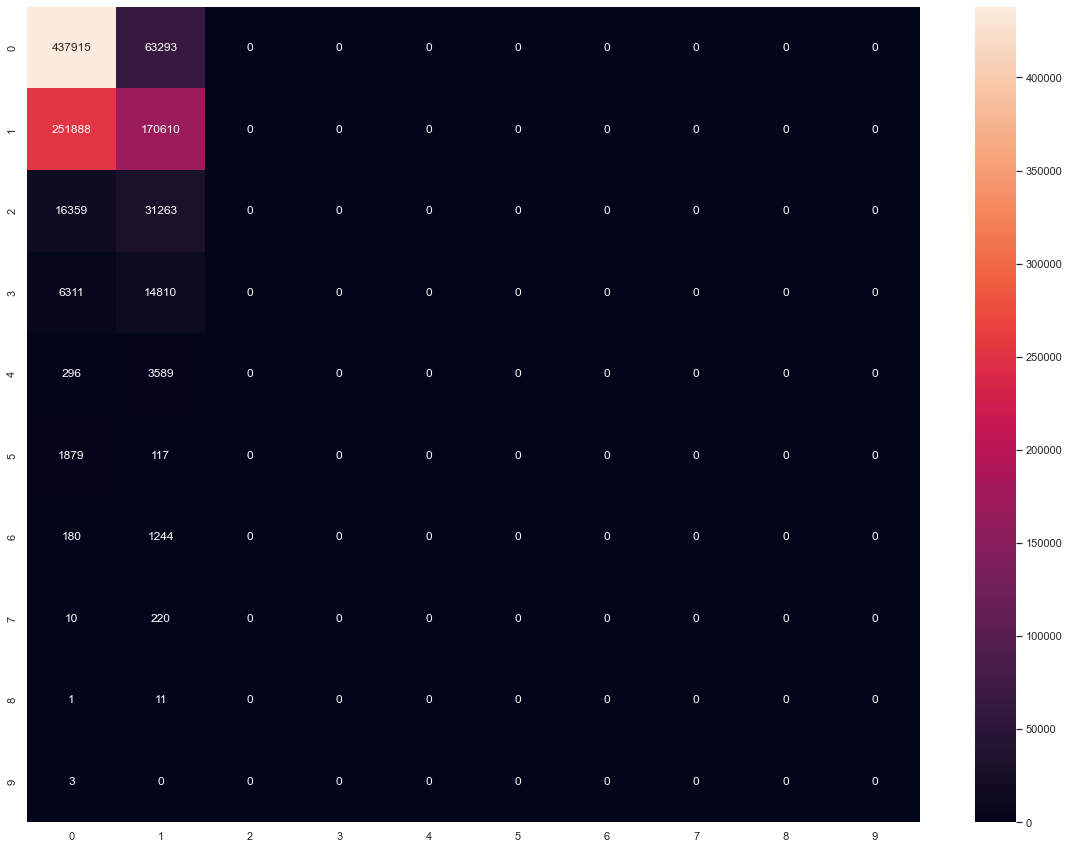

In [88]:
conf_matrix(y_test, y_preds)

###### 7.2.2.2 Preprocessed and Sampled Data

In [89]:
catboost_cv.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
0:	learn: 2.0456751	total: 54.6ms	remaining: 5.4s
1:	learn: 1.8526080	total: 105ms	remaining: 5.12s
2:	learn: 1.6995007	total: 157ms	remaining: 5.08s
3:	learn: 1.5721796	total: 183ms	remaining: 4.4s
4:	learn: 1.4632521	total: 218ms	remaining: 4.15s
5:	learn: 1.3681806	total: 271ms	remaining: 4.25s
6:	learn: 1.2829761	total: 306ms	remaining: 4.06s
7:	learn: 1.2084928	total: 339ms	remaining: 3.9s
8:	learn: 1.1404117	total: 385ms	remaining: 3.9s
9:	learn: 1.0796832	total: 432ms	remaining: 3.89s
10:	learn: 1.0238379	total: 458ms	remaining: 3.71s
11:	learn: 0.9726668	total: 505ms	remaining: 3.7s
12:	learn: 0.9253233	total: 551ms	remaining: 3.69s
13:	learn: 0.8813560	total: 596ms	remaining: 3.66s
14:	learn: 0.8404685	total: 641ms	remaining: 3.63s
15:	learn: 0.8023670	total: 680ms	remaining: 3.57s
16:	learn: 0.7669334	total: 729ms	remaining: 3.56s
17:	learn: 0.7337872	total: 775ms	remaining: 3.53s
18:	learn: 0.7024320	total: 806ms	

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000024009906E80>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 8, 10],
                         'iterations': [10, 20, 50, 100],
                         'learning_rate': [0.01, 0.02, 0.03]},
             verbose=2)

In [90]:
catboost_cv.best_estimator_.get_params()

{'iterations': 100, 'learning_rate': 0.03, 'depth': 10}

In [91]:
y_preds = CBC.predict(X_test_preprocessed)

In [92]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      1.00      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.92      1.00      0.96        12
           9       0.33      1.00      0.50         3

    accuracy                           1.00    999999
   macro avg       0.93      1.00      0.95    999999
weighted avg       1.00      1.00      1.00    999999



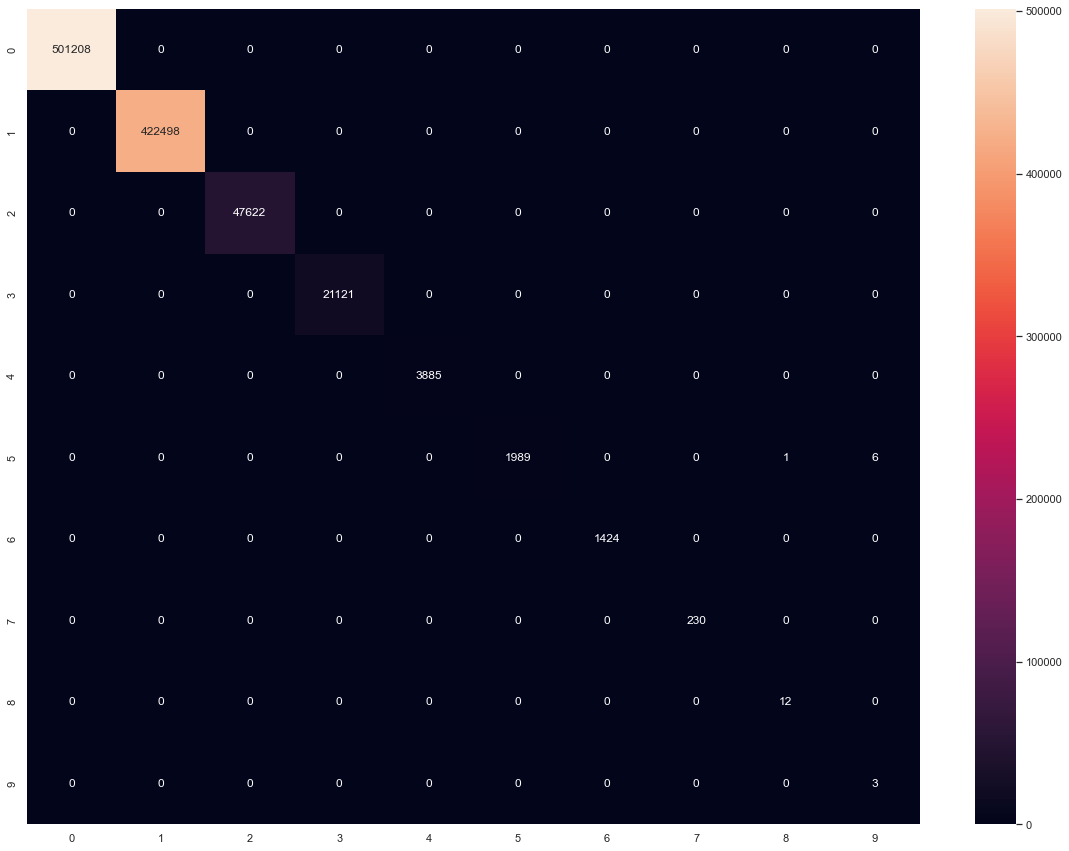

In [93]:
conf_matrix(y_test, y_preds)

#### 7.3 Neural Network

In [94]:
nn = MLPClassifier()

In [95]:
nn.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

##### 7.3.1 Training with default model of MLP Classifier

###### 7.3.1.1 Raw Data

In [96]:
nn.fit(X_train, y_train)

MLPClassifier()

In [97]:
y_preds = nn.predict(X_test)

In [98]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.70      0.86      0.77    501208
           1       0.64      0.59      0.61    422498
           2       0.44      0.02      0.03     47622
           3       0.49      0.03      0.06     21121
           4       0.00      0.00      0.00      3885
           5       0.00      0.00      0.00      1996
           6       1.00      0.00      0.00      1424
           7       0.22      0.07      0.11       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.68    999999
   macro avg       0.35      0.16      0.16    999999
weighted avg       0.66      0.68      0.65    999999



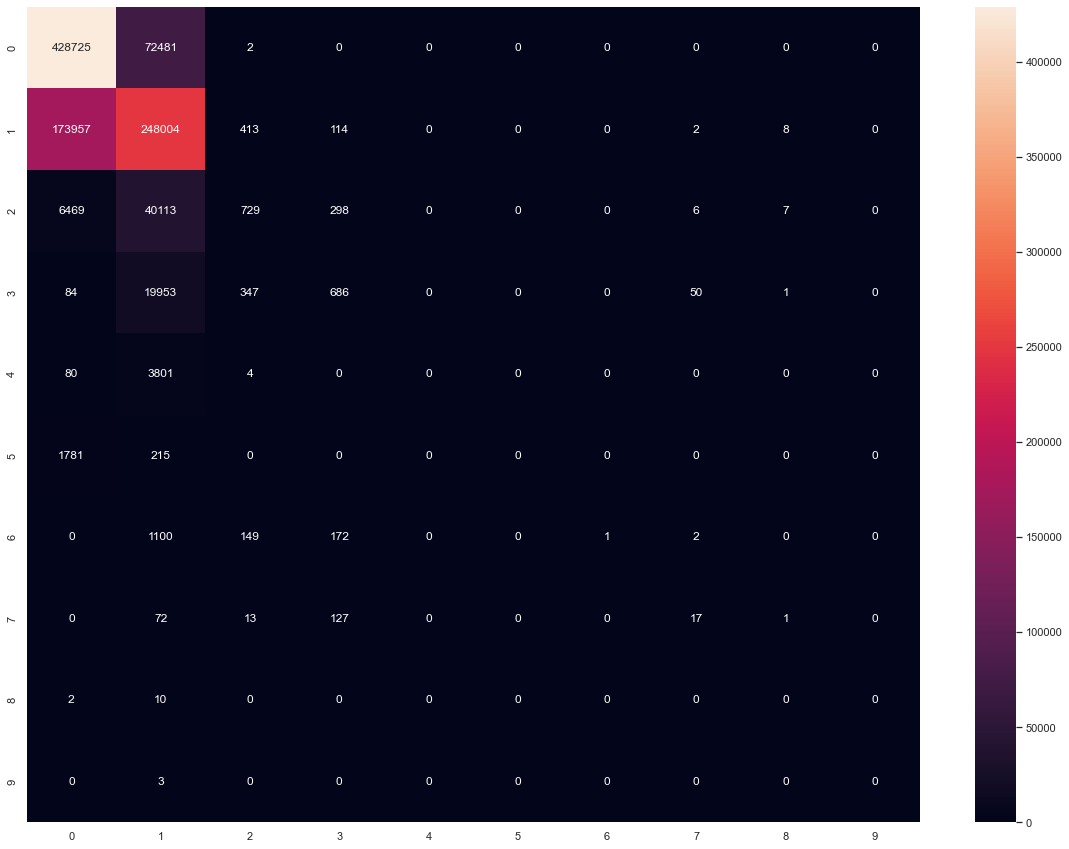

In [99]:
conf_matrix(y_test, y_preds)

###### 7.3.1.2 Preprocessed and Sampled Data

In [100]:
nn.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

MLPClassifier()

In [101]:
y_preds = nn.predict(X_test_preprocessed)

In [102]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      0.94      0.97      3885
           5       1.00      0.99      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.32      1.00      0.48        12
           9       0.21      1.00      0.35         3

    accuracy                           1.00    999999
   macro avg       0.85      0.99      0.88    999999
weighted avg       1.00      1.00      1.00    999999



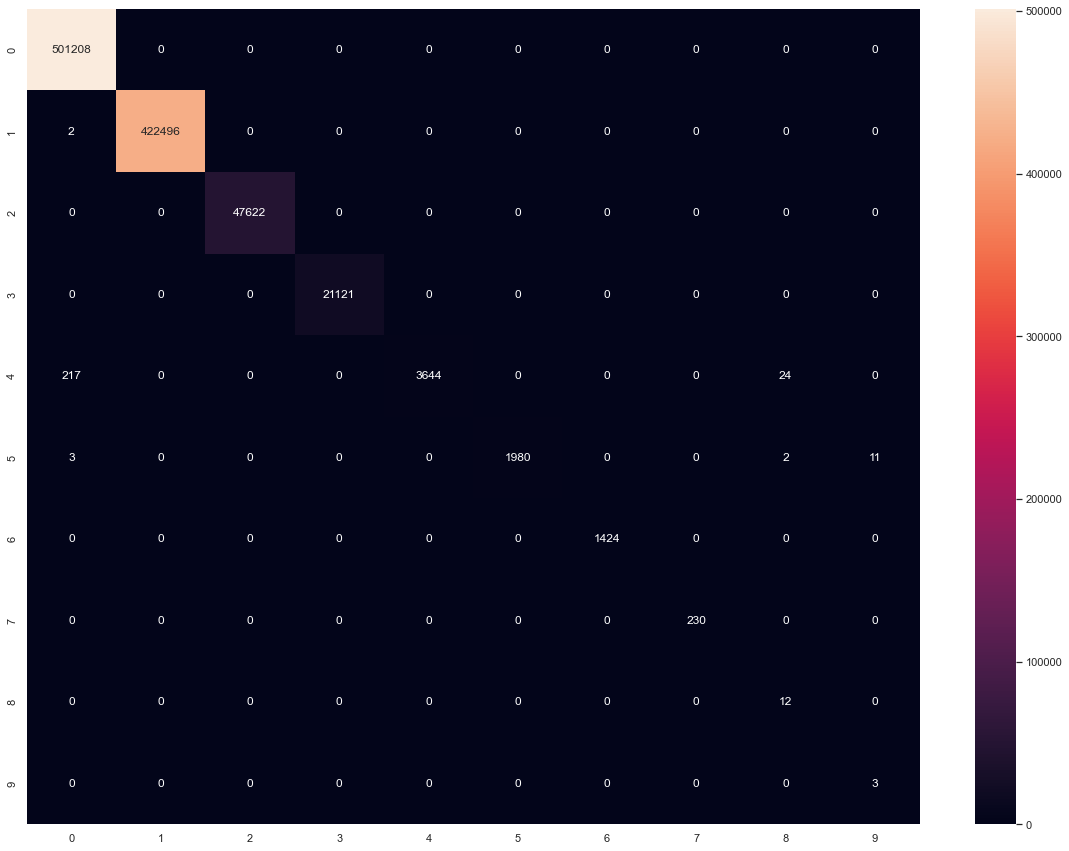

In [103]:
conf_matrix(y_test, y_preds)

##### 7.3.2 Hyperparameter Tunning of MLPClassifier and Training with Hyparameter tuned Model

In [104]:
parameters = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

nn_cv = GridSearchCV(nn, parameters, cv = 5, n_jobs = -1, verbose = 2)

###### 7.3.2.1 Raw Data

In [105]:
nn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=2)

In [106]:
nn_cv.best_estimator_.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (50, 100, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [107]:
y_preds = nn_cv.predict(X_test)

In [108]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       0.98      0.99      0.99     21121
           4       0.97      0.17      0.29      3885
           5       0.16      0.00      0.01      1996
           6       0.90      0.86      0.88      1424
           7       0.98      0.35      0.51       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.99    999999
   macro avg       0.70      0.54      0.57    999999
weighted avg       0.99      0.99      0.99    999999



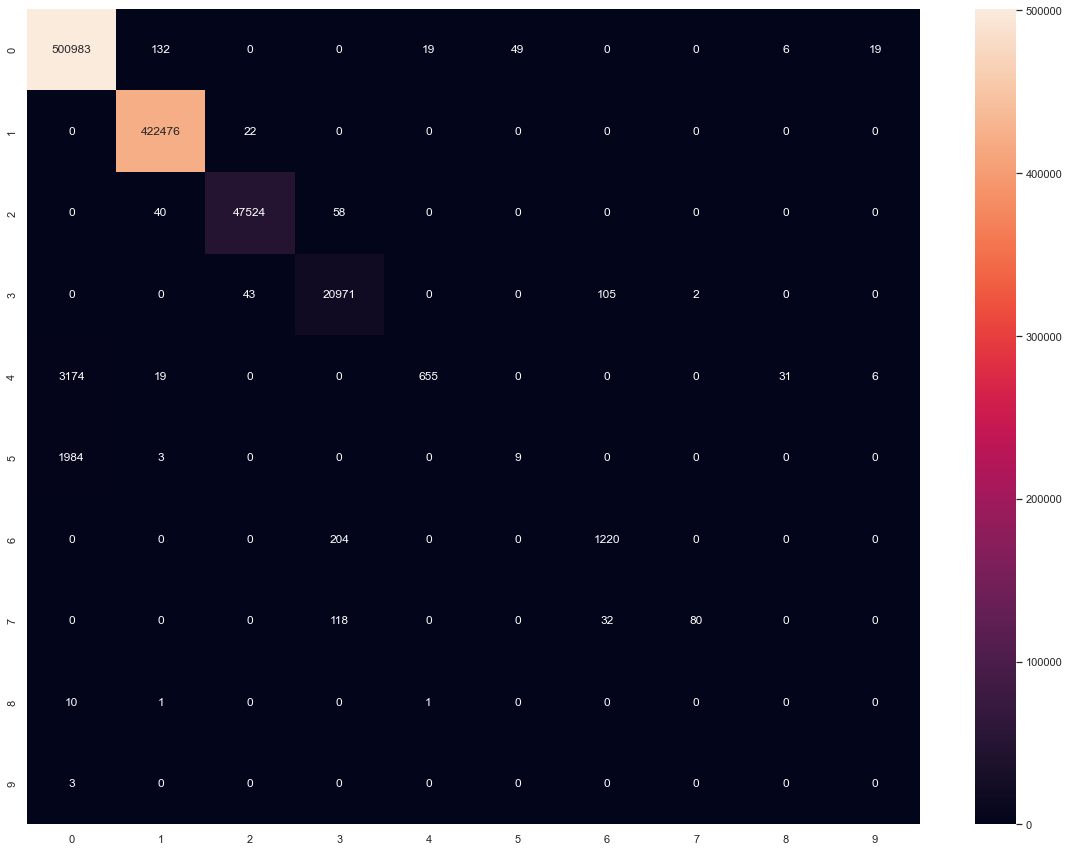

In [109]:
conf_matrix(y_test, y_preds)

###### 7.3.2.2 Preprocessed and Sampled Data

In [110]:
nn_cv.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=2)

In [111]:
nn_cv.best_estimator_.get_params()

{'activation': 'tanh',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (50, 50, 50),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [112]:
y_preds = nn_cv.predict(X_test_preprocessed)

In [113]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       0.92      1.00      0.96      3885
           5       1.00      0.99      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.75      1.00      0.86        12
           9       0.16      1.00      0.27         3

    accuracy                           1.00    999999
   macro avg       0.88      1.00      0.91    999999
weighted avg       1.00      1.00      1.00    999999



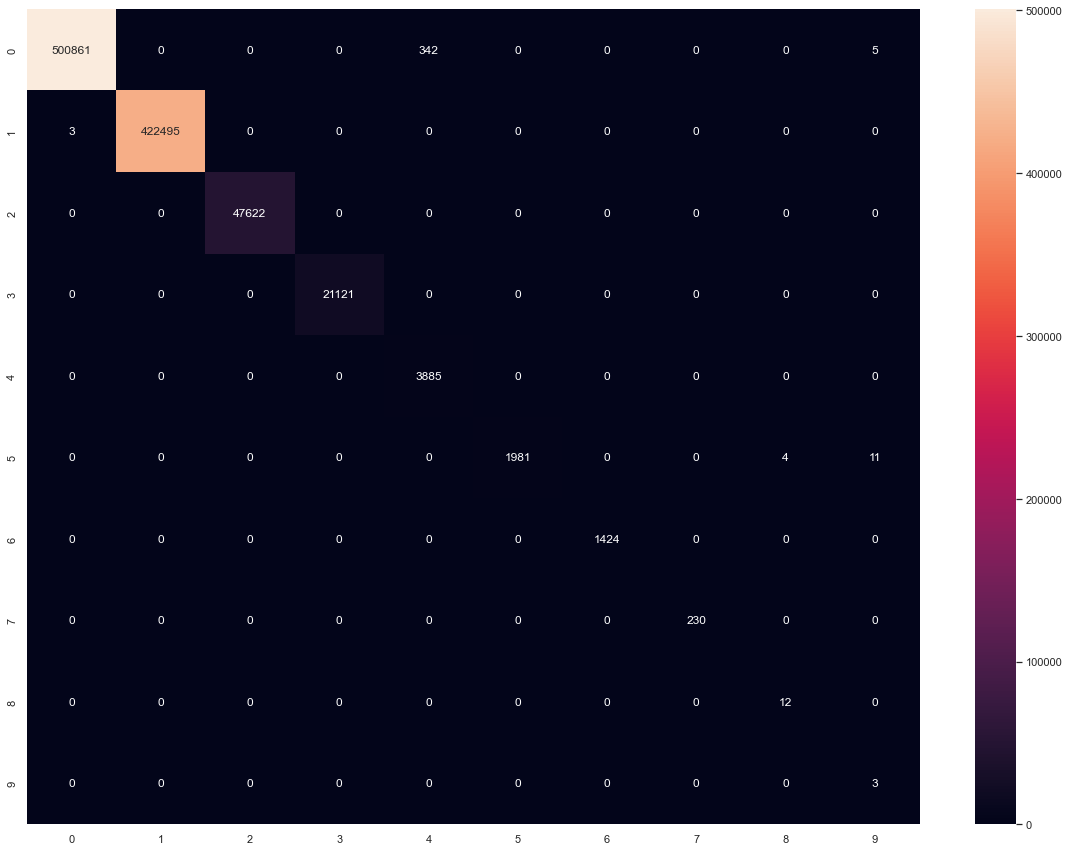

In [114]:
conf_matrix(y_test, y_preds)

#### 7.4 Random Forest

In [115]:
rf = RandomForestClassifier()

In [116]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

##### 7.4.1 Training with default model of Random Forest Classifier

###### 7.4.1.1 Raw Data

In [117]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [118]:
y_preds = rf.predict(X_test)

In [119]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.63      0.81      0.71    501208
           1       0.57      0.49      0.53    422498
           2       0.39      0.00      0.01     47622
           3       0.54      0.00      0.01     21121
           4       0.25      0.00      0.00      3885
           5       1.00      0.00      0.01      1996
           6       0.00      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.61    999999
   macro avg       0.34      0.13      0.13    999999
weighted avg       0.59      0.61      0.58    999999



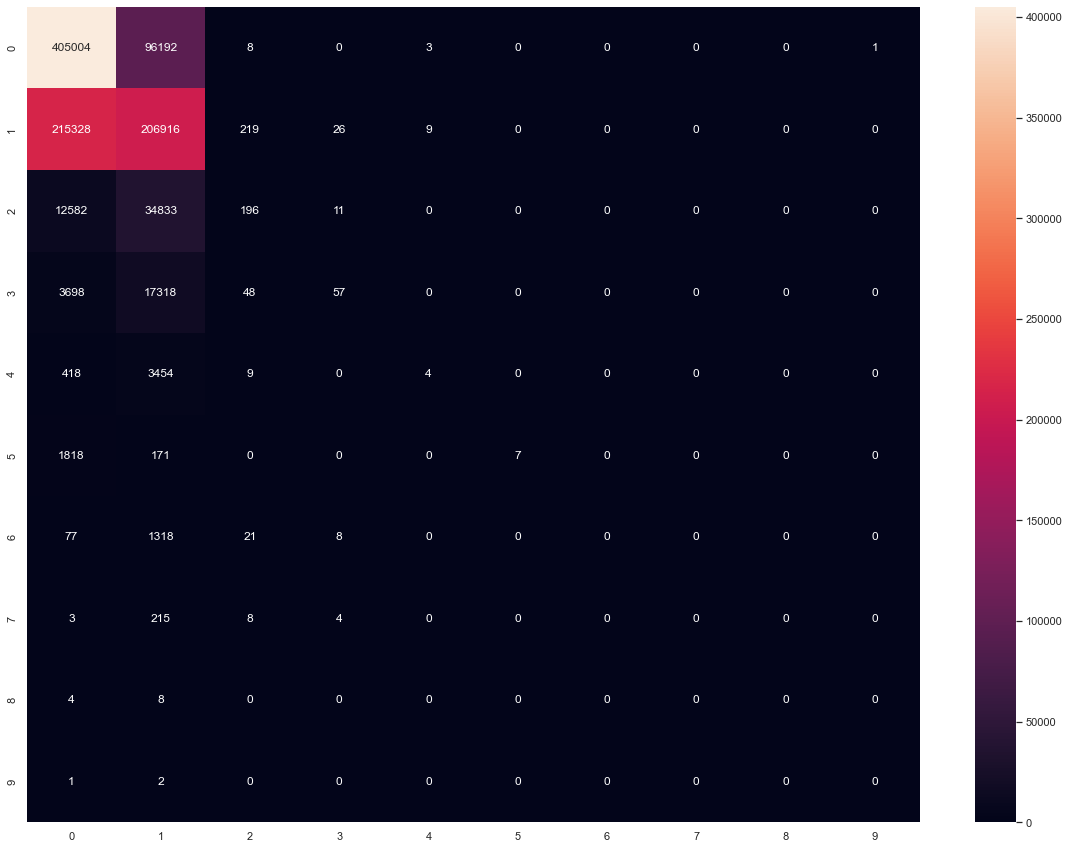

In [120]:
conf_matrix(y_test, y_preds)

###### 7.4.1.2 Preprocessed and Sampled Data

In [121]:
rf.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

RandomForestClassifier()

In [122]:
y_preds = rf.predict(X_test_preprocessed)

In [123]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      0.99      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       0.67      1.00      0.80        12
           9       0.27      1.00      0.43         3

    accuracy                           1.00    999999
   macro avg       0.89      1.00      0.92    999999
weighted avg       1.00      1.00      1.00    999999



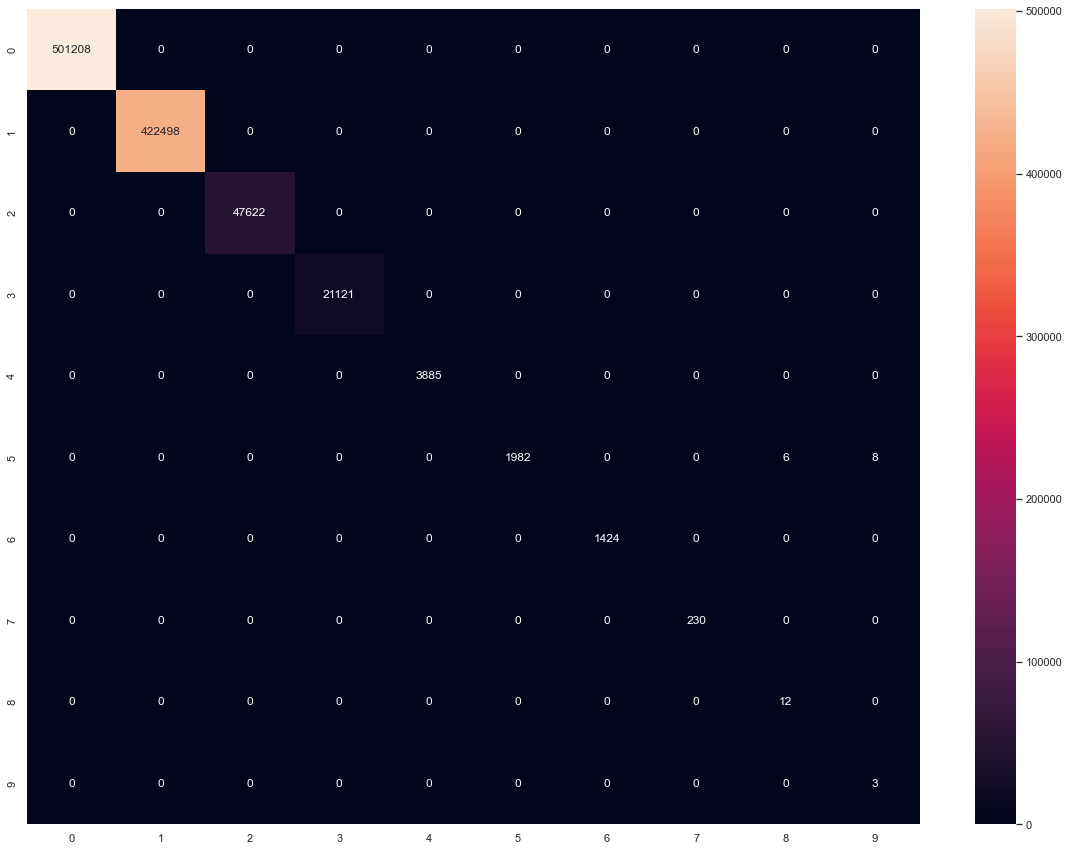

In [124]:
conf_matrix(y_test, y_preds)

##### 7.4.2 Hyperparameter Tunning of Random Forest Classifier and Training with Hyparameter tuned Model

In [125]:
parameters = {
    'n_estimators': [10,50,100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10,15,20,30],
    'max_features': ['auto', 'log2']
}

rf_cv = GridSearchCV(rf, parameters, cv = 5, n_jobs = -1, verbose = 2)

###### 7.4.2.1 Raw Data

In [126]:
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 30],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [10, 50, 100]},
             verbose=2)

In [128]:
rf_cv.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [129]:
y_preds = rf_cv.predict(X_test)

In [130]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       0.63      0.82      0.72    501208
           1       0.58      0.48      0.53    422498
           2       0.41      0.00      0.00     47622
           3       0.70      0.00      0.00     21121
           4       0.00      0.00      0.00      3885
           5       1.00      0.00      0.00      1996
           6       0.00      0.00      0.00      1424
           7       0.00      0.00      0.00       230
           8       0.00      0.00      0.00        12
           9       0.00      0.00      0.00         3

    accuracy                           0.61    999999
   macro avg       0.33      0.13      0.13    999999
weighted avg       0.60      0.61      0.58    999999



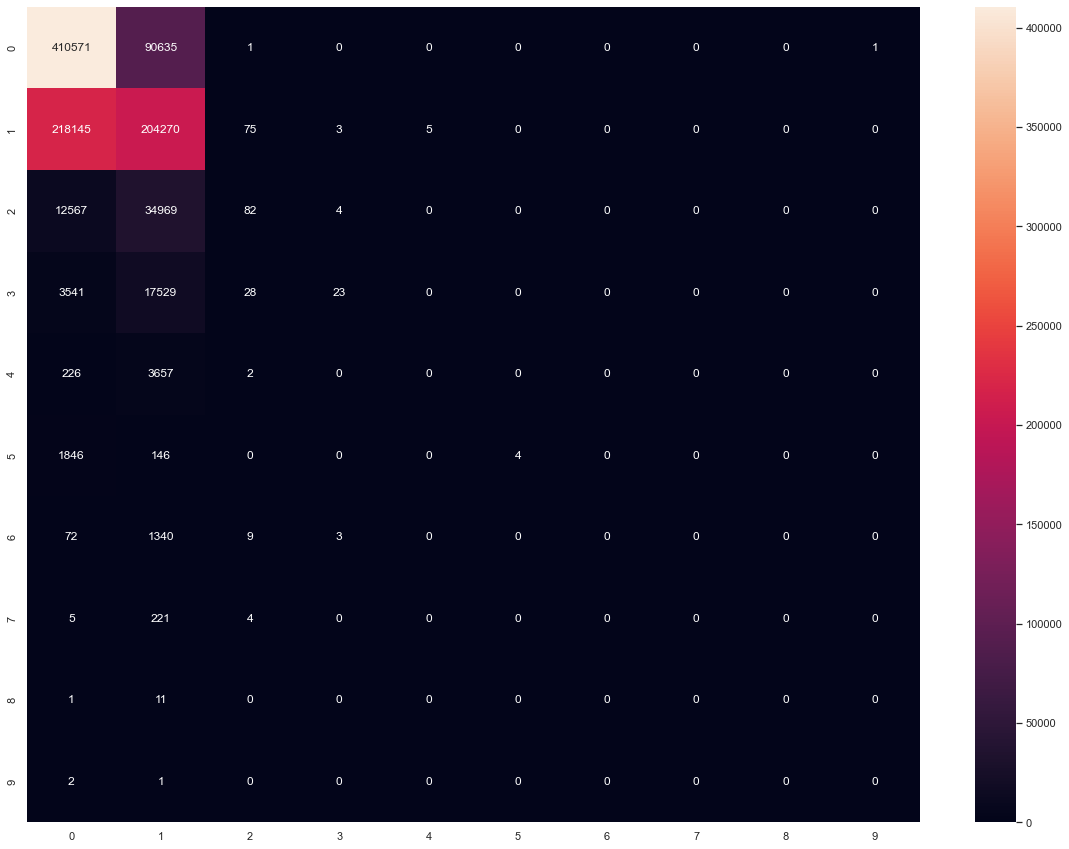

In [131]:
conf_matrix(y_test, y_preds)

###### 7.4.2.2 Preprocessed and Sampled Data

In [132]:
rf_cv.fit(X_train_preprocessed_oversampled, y_train_preprocessed_oversampled)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 30],
                         'max_features': ['auto', 'log2'],
                         'n_estimators': [10, 50, 100]},
             verbose=2)

In [133]:
rf_cv.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 30,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [134]:
y_preds = rf_cv.predict(X_test_preprocessed)

In [135]:
show_classification_report(y_test, y_preds)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      0.99      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       1.00      1.00      1.00        12
           9       0.19      1.00      0.32         3

    accuracy                           1.00    999999
   macro avg       0.92      1.00      0.93    999999
weighted avg       1.00      1.00      1.00    999999



## 9. Feature Importance and Feature Engineering Effect

What we will do in here is that, we will show how our feature engineering and preprocessing effected our best model and see the feature importance. 

In [177]:
def feature_importance_plot(model, X_train_preprocessed, title):
    plt.figure(figsize=(18,18))
    plt.barh(X_train_preprocessed.columns, np.argsort(model.feature_importances_))
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature Names")

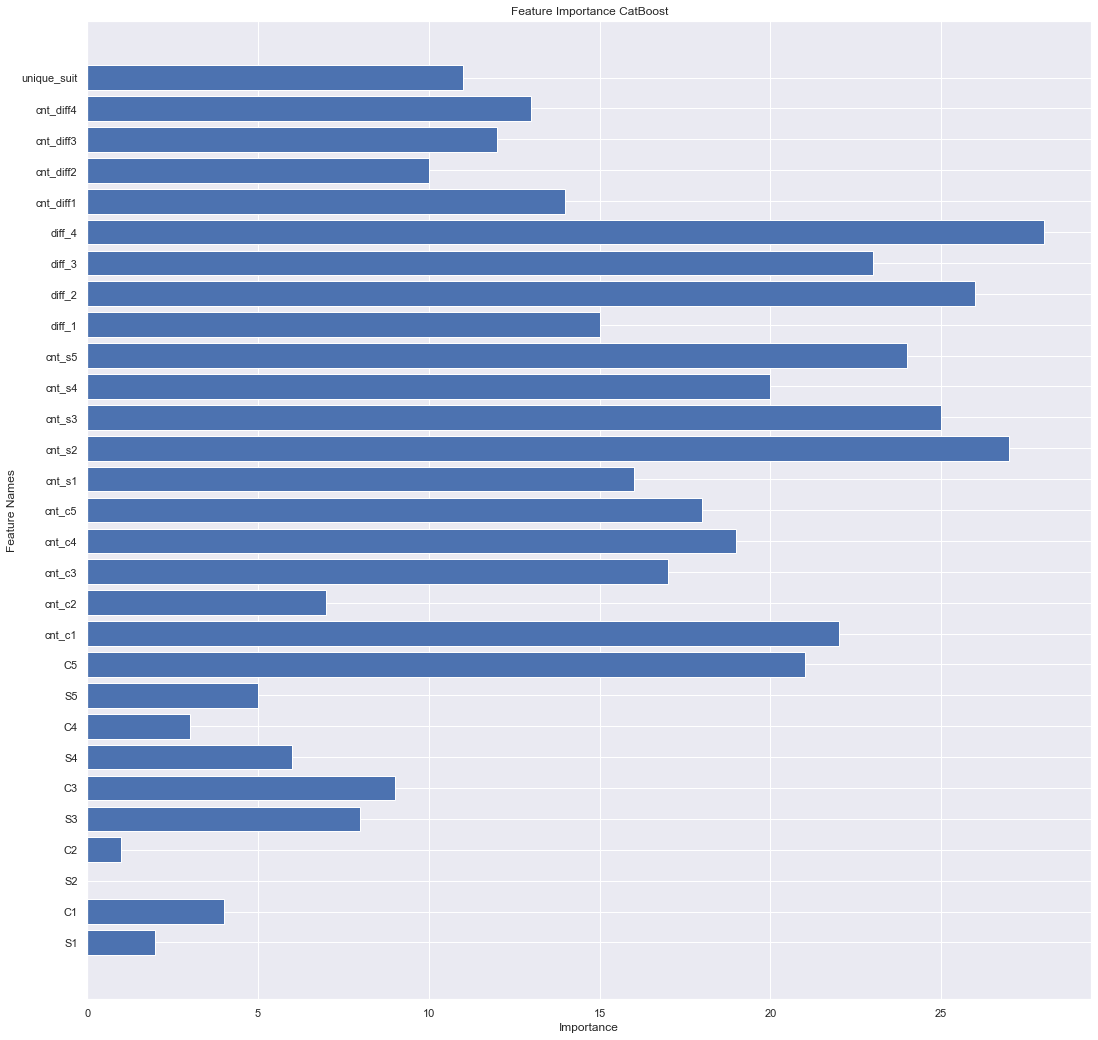

In [179]:
feature_importance_plot(catboost_cv.best_estimator_, X_train_preprocessed, "Feature Importance CatBoost")

As you can see from the plot above, the new generated columns are dramatically effecting the way our model predicts.

## 10. Using Full SMOTE with the best model.

In the Model Training section we saw that there were still some problems about rare classes (8 and 9).\
So in this section what we are trying to do is that we will use SMOTE without giving weights and oversample our training data.\
After that, we will see the classification report of our best models (XGBoost and CatBoost) once again, with hopes of getting a better result.

In [222]:
sm = SMOTE(k_neighbors=3, random_state=42)

X_train_full_oversampled, y_train_full_oversampled = sm.fit_resample(X_train_preprocessed, y_train)

In [223]:
X_train_full_oversampled.shape, y_train_full_oversampled.shape

((124930, 29), (124930,))

In [224]:
Counter(y_train_full_oversampled)

Counter({9: 12493,
         8: 12493,
         1: 12493,
         0: 12493,
         4: 12493,
         3: 12493,
         2: 12493,
         5: 12493,
         6: 12493,
         7: 12493})

#### 10.1 CatBoost

In [225]:
model = catboost_cv.best_estimator_

model.fit(X_train_full_oversampled, y_train_full_oversampled)

0:	learn: 2.0422532	total: 161ms	remaining: 15.9s
1:	learn: 1.8473174	total: 293ms	remaining: 14.3s
2:	learn: 1.6923426	total: 449ms	remaining: 14.5s
3:	learn: 1.5634839	total: 601ms	remaining: 14.4s
4:	learn: 1.4536460	total: 755ms	remaining: 14.3s
5:	learn: 1.3577114	total: 911ms	remaining: 14.3s
6:	learn: 1.2728037	total: 1.02s	remaining: 13.6s
7:	learn: 1.1975606	total: 1.18s	remaining: 13.6s
8:	learn: 1.1302707	total: 1.31s	remaining: 13.3s
9:	learn: 1.0691926	total: 1.47s	remaining: 13.2s
10:	learn: 1.0132636	total: 1.6s	remaining: 12.9s
11:	learn: 0.9618849	total: 1.75s	remaining: 12.9s
12:	learn: 0.9147083	total: 1.86s	remaining: 12.5s
13:	learn: 0.8710529	total: 2.02s	remaining: 12.4s
14:	learn: 0.8305413	total: 2.18s	remaining: 12.3s
15:	learn: 0.7928602	total: 2.33s	remaining: 12.2s
16:	learn: 0.7575436	total: 2.48s	remaining: 12.1s
17:	learn: 0.7245465	total: 2.62s	remaining: 11.9s
18:	learn: 0.6933892	total: 2.77s	remaining: 11.8s
19:	learn: 0.6641448	total: 2.9s	remaining

In [226]:
y_preds = model.predict(X_test_preprocessed)

In [227]:
print("Classification Report for test set:")
show_classification_report(y_test, y_preds)

Classification Report for test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      0.98      0.99      1996
           6       0.96      1.00      0.98      1424
           7       1.00      0.76      0.86       230
           8       0.55      1.00      0.71        12
           9       0.13      1.00      0.23         3

    accuracy                           1.00    999999
   macro avg       0.86      0.97      0.88    999999
weighted avg       1.00      1.00      1.00    999999



In [228]:
y_preds = model.predict(X_train_full_oversampled)

In [229]:
print("Classification Report for train set:")
show_classification_report(y_train_full_oversampled, y_preds)

Classification Report for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12493
           1       1.00      1.00      1.00     12493
           2       1.00      1.00      1.00     12493
           3       1.00      1.00      1.00     12493
           4       1.00      1.00      1.00     12493
           5       1.00      1.00      1.00     12493
           6       1.00      1.00      1.00     12493
           7       1.00      1.00      1.00     12493
           8       1.00      1.00      1.00     12493
           9       1.00      1.00      1.00     12493

    accuracy                           1.00    124930
   macro avg       1.00      1.00      1.00    124930
weighted avg       1.00      1.00      1.00    124930



#### 10.2 XGBoost

In [230]:
model = xgboost_cv.best_estimator_

model.fit(X_train_full_oversampled, y_train_full_oversampled)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [231]:
y_preds = model.predict(X_test_preprocessed)

In [232]:
print("Classification Report for test set:")
show_classification_report(y_test, y_preds)

Classification Report for test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    501208
           1       1.00      1.00      1.00    422498
           2       1.00      1.00      1.00     47622
           3       1.00      1.00      1.00     21121
           4       1.00      1.00      1.00      3885
           5       1.00      0.99      1.00      1996
           6       1.00      1.00      1.00      1424
           7       1.00      1.00      1.00       230
           8       1.00      1.00      1.00        12
           9       0.17      1.00      0.29         3

    accuracy                           1.00    999999
   macro avg       0.92      1.00      0.93    999999
weighted avg       1.00      1.00      1.00    999999



In [233]:
y_preds = model.predict(X_train_full_oversampled)

In [234]:
print("Classification Report for train set:")
show_classification_report(y_train_full_oversampled, y_preds)

Classification Report for train set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12493
           1       1.00      1.00      1.00     12493
           2       1.00      1.00      1.00     12493
           3       1.00      1.00      1.00     12493
           4       1.00      1.00      1.00     12493
           5       1.00      1.00      1.00     12493
           6       1.00      1.00      1.00     12493
           7       1.00      1.00      1.00     12493
           8       1.00      1.00      1.00     12493
           9       1.00      1.00      1.00     12493

    accuracy                           1.00    124930
   macro avg       1.00      1.00      1.00    124930
weighted avg       1.00      1.00      1.00    124930



Even though oversampling (without giving weights) might be a good idea, it isn't always giving good results.\
In this case (Section 10) it seems our models overfitting.

## 11. Saving Models and Data Using Pickle

In [235]:
rf_best_model = rf_cv.best_estimator_
nn_best_model = nn_cv.best_estimator_
catboost_model = catboost_cv.best_estimator_
xgboost_model = xgboost_cv.best_estimator_

rf_model_file = open("rf_model.pickle", "wb")
nn_model_file = open("nn_model.pickle", "wb")
catboost_model_file = open("catboost_model.pickle", "wb")
xgboost_model_file = open("xgboost_model.pickle", "wb")

pickle.dump(rf_best_model, rf_model_file)
pickle.dump(nn_best_model, nn_model_file)
pickle.dump(catboost_model, catboost_model_file)
pickle.dump(xgboost_model, xgboost_model_file)

In [237]:
!pip freeze > requirements.txt